# Explainable AI using Credit Card Data

In this notebook, we consider an imbalanced dataset of credit card frauds (with the target labels being authentic and fraudulent), build and assess explainability of different anomaly detection system in predicting anomalies in credit card transactions.

## Key Objectives

1. Where anomaly detectors agree on predictions, do they give rise to similar SHAP value explanations? How about when they disagree?

2. How does missing data impact anomaly detection? Are different anomaly detection algorithms better suited for datasets where there are more missing values?

In [278]:
!pip install numpy==1.20
# Importing the necessary packages and setting the enviroment
import warnings
warnings.filterwarnings("ignore")


import time, psutil, os, gc

# Mathematical functions
import math

# Data manipulation
import numpy as np
np.bool = np.bool_
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyod.models.knn import KNN  # Example anomaly detector
import shap  # For SHAP values explanation
# Fit SHAP explainer and obtain SHAP values f
# Plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Train-test split
from sklearn.model_selection import train_test_split

# Progress bar for loop
from tqdm.contrib import itertools

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 1.4 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-ensemble 0.2.1 requires seaborn>=0.11.2, which is not installed.
shapash 1.3.1 requires seaborn==0.11.1, which is not installed.
fastparquet 2023.10.1 requires numpy>=1.20.3, but you have numpy 1.20.0 which is incompatible.
fastparquet 2023.10.1 requires pandas>=1.5.0, but you have pandas 1.4.4 which is incompatible.
key-driver-analysis 0.1.2 requires numpy>=1.21.3, but you have numpy 1.20.0 which is incompatible.
lazypredict 0.2.9 requires click==7.1.2, but you have click 8.1.4 which is incompat


# Data

Source: https://www.kaggle.com/mlg-ulb/creditcardfraud

The dataset contains information on the transactions made using credit cards by European cardholders, in two particular days of September 2013
. It presents a total of 284807 transactions, of which 492 were fraudulent. Clearly, the dataset is highly imbalanced, the positive class (fraudulent transactions) accounting for only 0.173%

of all transactions. The columns in the dataset are as follows:

Time: The time (in seconds) elapsed between the transaction and the very first transaction 

V1 to V28: Obtained from principle component analysis (PCA) transformation on original features that are not available due to confidentiality

Amount: The amount of the transaction

Class: The status of the transaction with respect to authenticity. The class of an authentic (resp. fraudulent) transaction is taken to be 0

In [279]:
df = pd.read_csv("creditcard.csv")
# Check the shape of the dataset
print("Shape of the dataset:", df.shape)
# Check the first few rows of the dataset
data=df
df.head()

Shape of the dataset: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Sub-sample with all minority class retained.

To improve on computational efficiecy of shap calculations, we are doing a sub-sample of n=50000, where all the minority class (fraudulent transactions) are retained.

In [280]:
df=data
# Calculate the class distribution in the original DataFrame
class_counts = df['Class'].value_counts()

# Identify minority classes
minority_classes = class_counts[class_counts < df.shape[0] // len(class_counts)].index.tolist()

# Create a sub-sample DataFrame
sub_sample = pd.DataFrame()

# Desired size of the sub-sample
desired_size = 50000

# Add all instances of minority classes
for cls in minority_classes:
    class_subset = df[df['Class'] == cls]
    sub_sample = pd.concat([sub_sample, class_subset], axis=0)

# For majority classes, sample with replacement to reach desired size
for cls in df['Class'].unique():
    if cls not in minority_classes:
        class_subset = df[df['Class'] == cls]
        num_samples = min(len(class_subset), desired_size - len(sub_sample))
        class_subset_sampled = class_subset.sample(n=num_samples, replace=True, random_state=1)
        sub_sample = pd.concat([sub_sample, class_subset_sampled], axis=0)
        if len(sub_sample) >= desired_size:
            break

# Shuffle the sub-sample to mix the classes (optional)
sub_sample = sub_sample.sample(frac=1, random_state=1).reset_index(drop=True)
df=sub_sample
df = df.fillna(df.mean())
df.shape

(50000, 31)

# Feature Engineering

## Time

In [281]:
df['Day'], temp = df['Time'] // (24*60*60), df['Time'] % (24*60*60)
df['Hour'], temp = temp // (60*60), temp % (60*60)
df['Minute'], df['Second'] = temp // 60, temp % 60
print(df.shape)
df[['Time', 'Day', 'Hour', 'Minute', 'Second']].tail()

(50000, 35)


,Time,Day,Hour,Minute,Second
49995,63667.0,0.0,17.0,41.0,7.0
49996,23650.0,0.0,6.0,34.0,10.0
49997,144440.0,1.0,16.0,7.0,20.0
49998,89420.0,1.0,0.0,50.0,20.0
49999,36611.0,0.0,10.0,10.0,11.0


## Amount

The distribution of `Amount` has extreme positive skewness. We apply the transformation $x \mapsto \log{\left(x + 0.001\right)}$ to this column and form the new column `Amount_transformed`. The positive constant $0.001$ is added to deal with the zero-amount transactions, which leads to $\log{0}$, an undefined quantity.

In [282]:
df['Amount'] = np.log10(df['Amount'] + 0.001)
df.shape

(50000, 35)

In [283]:
df=df.fillna(df.mean())

In [284]:
X=df.drop('Class',axis=1)
y=df['Class']

# Feature Selection

To reduce the dimensionality and increase the computional efficiency of Shap calculations, we will use the following methods to select 10 features from the dataframe.

## (a) Recursive Feature Elimination (RFE)

RFE works by recursively removing the least important features based on a specified estimator. Here's an example using RFE with LogisticRegression as the estimator:

In [285]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Initialize RFE with RandomForestClassifier estimator
estimator = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator, n_features_to_select=10, verbose=1)
# Fit RFE
rfe.fit(X, y)
# Get selected feature indices
selected_feature_indices = rfe.support_

# Filter original feature names to get selected feature names
Feature_names_RFE= [f'Feature_{i}' for i in range(X.shape[1]) if selected_feature_indices[i]]

# Print selected feature names
print("Selected Feature Names:")
print(Feature_names_RFE)

Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Selected Feature Names:
['Feature_4', 'Feature_7', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_14', 'Feature_16', 'F

## (b) SelectFromModel with Random Forest Classifier

SelectFromModel is a meta-transformer that can be used with any estimator that assigns importance to features (e.g., tree-based methods, linear models with coef_ attribute). Here’s an example using SelectFromModel with RandomForestClassifier:

In [286]:
from sklearn.feature_selection import SelectFromModel

# Initialize RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize SelectFromModel with RandomForestClassifier estimator
sfm = SelectFromModel(clf, threshold='median')

# Fit SelectFromModel
sfm.fit(X, y)

# Get selected feature indices
selected_feature_indices = sfm.get_support()

# Filter original feature names to get selected feature names
Feature_names_SFM = [f'Feature_{i}' for i in range(X.shape[1]) if selected_feature_indices[i]]

# Print selected feature names
print("Selected Feature Names:")
print(Feature_names_SFM)

Selected Feature Names:
['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_6', 'Feature_7', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_21']


# (c) BorutaPy

Boruta is a feature selection method that selects all relevant features by comparing the importance of original features with that of randomized shadow features. It helps in identifying features that contribute significantly to the prediction task.

In [287]:
!pip install  boruta 

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 462.8 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [289]:
from boruta import BorutaPy

# Initialize RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize BorutaPy
boruta_selector = BorutaPy(rf, n_estimators=10, verbose=2)

# Fit BorutaPy
boruta_selector.fit(X, y)

# Get selected feature indices
selected_feature_indices = boruta_selector.support_

# Filter original feature names to get selected feature names
Feature_names_BP = [f'Feature_{i}' for i in range(X.shape[1]) if selected_feature_indices[i]]

# Print selected feature names
print("Selected Feature Names:")
print(Feature_names_BP)

InvalidIndexError: (slice(None, None, None), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]))

In [291]:
common_selected_features=set(Feature_names_RFE) & set(Feature_names_SFM)&set(Feature_names_BP)
common_selected_features

NameError: name 'Feature_names_BP' is not defined

In [370]:
ind=[3,6,8,9,10,11,13,15,16,17]
cols=[]
for i in ind:
    cols.append(df.columns[i])
cols

['V3', 'V6', 'V8', 'V9', 'V10', 'V11', 'V13', 'V15', 'V16', 'V17']

In [371]:
X=X[cols]

In [372]:
X.head()

,V3,V6,V8,V9,V10,V11,V13,V15,V16,V17
0,-0.128481,0.671886,0.222877,-0.335815,1.192073,-0.138481,-1.014406,-2.781393,0.652068,-0.454096
1,-0.032974,0.656291,0.526633,0.019921,0.593827,-0.537407,-1.820042,1.148093,0.311786,-0.404971
2,0.161858,-0.491688,-0.195949,-1.325639,0.951116,-0.769259,0.408908,-0.675317,-0.857246,0.828554
3,0.389526,0.200254,0.043669,0.984731,-0.519600,-0.495843,0.315549,-0.034359,-0.334877,0.395783
4,-4.128009,6.124611,-2.054787,-1.305546,-1.555800,-0.435584,-0.292325,-0.432640,0.408012,-0.175397


In [373]:
X.describe().T.style.background_gradient(axis=0, cmap='Greens')

,count,mean,std,min,25%,50%,75%,max
V3,50000.000000,0.000000,1.000000,-17.737567,-0.491411,0.135335,0.616021,2.291324
V6,50000.000000,0.000000,1.000000,-15.584510,-0.570933,-0.200585,0.298019,15.936107
V8,50000.000000,-0.000000,1.000000,-31.110059,-0.159071,0.015446,0.247354,15.000701
V9,50000.000000,-0.000000,1.000000,-11.749869,-0.560687,-0.033693,0.543563,9.097665
V10,50000.000000,-0.000000,1.000000,-19.174544,-0.387649,-0.043971,0.378887,12.016578
V11,50000.000000,-0.000000,1.000000,-3.565848,-0.718964,-0.046756,0.657039,10.950732
V13,50000.000000,-0.000000,1.000000,-3.806463,-0.652796,-0.011431,0.663662,4.086162
V15,50000.000000,0.000000,1.000000,-4.946022,-0.637536,0.050403,0.710340,5.290158
V16,50000.000000,0.000000,1.000000,-14.033340,-0.441862,0.094029,0.550423,5.202399
V17,50000.000000,-0.000000,1.000000,-20.826242,-0.359556,-0.013840,0.372055,6.489650


## Scaling and Splitting the data

In [374]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit and transform the data
X =(X-X.mean())/X.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [376]:
X_test.shape, y_test.shape

((10000, 10), (10000,))

In [296]:
import os
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
#import umap
import xgboost
from lime.lime_tabular import LimeTabularExplainer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import IsolationForest
from lightgbm import LGBMClassifier
from pyod.models.knn import KNN
from pyod.models.iforest import IForest

In [297]:
data, labels = X,y

# Get categorical column indexes
cat_columns_ix_ = {
    c: i
    for i, c in enumerate(data.columns)
    if pd.api.types.is_categorical_dtype(data[c])
}
# categorical column names
cat_columns = [c for c in (data.columns) if pd.api.types.is_categorical_dtype(data[c])]

# Make copies of data with various representations for categorical features.
data_numeric = data.copy()  # categorical fields are label encoded but numerical
data_categorical = (
    data.copy()
)  # categorical fields are label encoded, numeric but categorical type
data_ohe = pd.get_dummies(
    data, columns=cat_columns, sparse=False
)  # categorical fields are one hot encoded

# Convert categorical columns to numeric encoded labels
for col in cat_columns:
    data_numeric[col] = LabelEncoder().fit_transform(data_numeric[col])
    data_categorical[col] = data_numeric[col].astype("category")


# Set data used for explorations
# Hint .. Change this to other version of the data and observe changes in results.
current_data = data_categorical
print("Available features: \n", list(data_categorical.columns))
print("Label Balance - [Authentic, Fraudulent] : ", list(labels.value_counts()))

Available features: 
 ['V3', 'V6', 'V8', 'V9', 'V10', 'V11', 'V13', 'V15', 'V16', 'V17']
Label Balance - [Authentic, Fraudulent] :  [49508, 492]


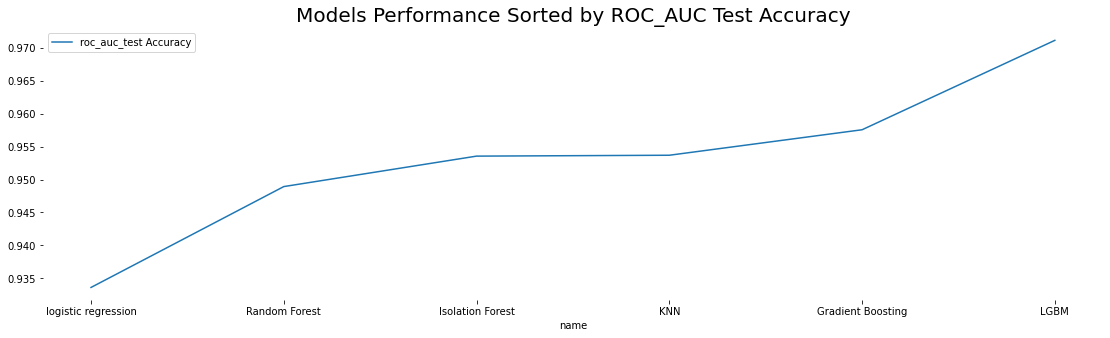

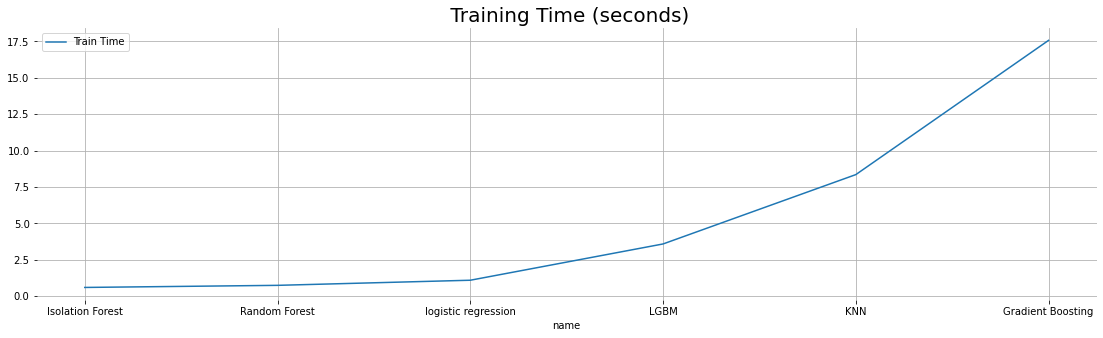

In [424]:
trained_models = [] #  keep track of all details for models we train

def train_model(model, data, labels): 
    X = data
    y = labels.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    pipe = Pipeline([('scaler', StandardScaler()),('clf', model["clf"])])
    start_time = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - start_time
    pred_train=pipe.predict(X_train)
    pred_test=pipe.predict(X_test)
    score_train=pipe.predict_proba(X_train)
    y_score_train=score_train[:,1]
    score_test=pipe.predict_proba(X_test)
    y_score_test=score_test[:,1]

    train_accuracy = roc_auc_score(y_train,y_score_train)
    test_accuracy  =roc_auc_score(y_test,y_score_test) 
    model_details = {"name": model["name"], "roc_auc_train_accuracy":train_accuracy, "roc_auc_test_accuracy":test_accuracy, "train_time": train_time, "model": pipe}
    return model_details

def train_model2(model, data, labels): 
    X = data
    y = labels.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    pipe = Pipeline([('scaler', StandardScaler()),('clf', model["clf"])])
    start_time = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - start_time
    pred_train=pipe.predict(X_train)
    pred_test=pipe.predict(X_test)
    y_score_train= pipe.decision_function(X_train)
    y_score_test=pipe.decision_function(X_test)

    train_accuracy = roc_auc_score(y_train,y_score_train)
    test_accuracy  =roc_auc_score(y_test,y_score_test) 
    model_details = {"name": model["name"], "roc_auc_train_accuracy":train_accuracy, "roc_auc_test_accuracy":test_accuracy, "train_time": train_time, "model": pipe}
    return model_details

models = [
          {"name": "logistic regression", "clf": LogisticRegressionCV()}, 
          {"name": "Random Forest", "clf": RandomForestClassifier(criterion='entropy', max_features=0.31096155614096943,
                       max_leaf_nodes=161, n_estimators=12, n_jobs=-1)},
          {"name": "Gradient Boosting", "clf": GradientBoostingClassifier(n_estimators=100)},
          {"name": "LGBM", "clf":LGBMClassifier(learning_rate=0.054035619656969944, max_bin=511,
               min_child_samples=11, n_estimators=1360, num_leaves=44,
               reg_alpha=0.002947632445703634, reg_lambda=0.01268422625516522,
               verbose=-1)}]

models2=[
          {"name": "KNN", "clf": KNN(algorithm='auto', leaf_size=10,
   metric='euclidean', metric_params=None, n_jobs=1, n_neighbors=5, p=2)},
          {"name": "Isolation Forest", "clf": IForest(bootstrap=False,  max_features=0.7,
     max_samples=0.5, n_estimators=50, n_jobs=1, random_state=None,verbose=0)}]

for model in models:
    model_details = train_model(model, current_data, labels) 
    trained_models.append(model_details)
for model in models2:
    model_details = train_model2(model, current_data, labels) 
    trained_models.append(model_details)



# visualize accuracy and run time
#setup_plot()
model_df = pd.DataFrame(trained_models)
model_df.sort_values("roc_auc_test_accuracy", inplace=True) 
ax = model_df[["roc_auc_test_accuracy", "name"]].plot(kind="line", x="name", figsize=(19,5), title="Models Performance Sorted by ROC_AUC Test Accuracy")
ax.legend( ["roc_auc_test Accuracy"])
for p in ax.patches:
    ax.annotate( str( round(p.get_height(),3) ), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.title.set_size(20)
plt.box(False)
plt.savefig("exp26.pdf", format="pdf", bbox_inches="tight",dpi=1000)

model_df.sort_values("train_time", inplace=True)
ax= model_df[["train_time","name"]].plot(kind="line", x="name", figsize=(19,5), grid=True, title=" Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time"])
plt.box(False)
plt.savefig("exp27.pdf", format="pdf", bbox_inches="tight",dpi=1000)

# Explaining Models
At this point, we have a few models trained, and we can use them to obtain explanation for each feature contributions.We can think of these explanations in global terms (i.e., how does each feature impact outcomes on the average for the entire datasheet?) or in local terms (i.e., how does each feature impact predictions for a specific instance?). Some models have inbuilt properties that provide these sorts of explanations. These are typically referred to as **white box** models and examples include linear regression (model coefficients), logistic regression (model coefficients) and decision trees (feature importance). Due to their complexity, other models - such as Random Forests, Gradient Boosted Trees, SVMs, Neural Networks etc. - do not have straightforward methods for explaining their predictions. For these models, (also known as **black box models**), approaches such as **LIME** and **SHAP** can be applied.

## Global Explanation - Logistic Regression Coefficients
For models such as logistic regression, we can look at the model coefficients to infer feature importance (note that coefficients need to be interpreted with care for each model type). This gives us some idea of how an increase/change in each feature might result in a change in the log odds. We can also get a general understanding of how important a feature is for the entire dataset.

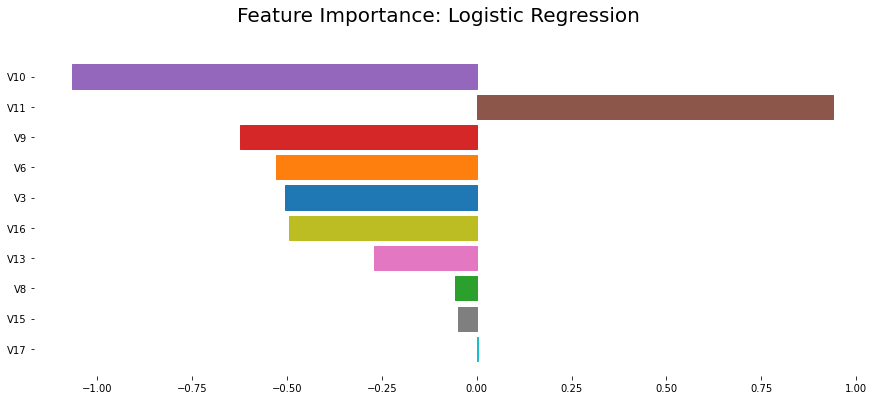

In [426]:
plt.figure(figsize=(15,6))

X_train, X_test, y_train, y_test = train_test_split(current_data, labels.values, random_state=42)

logistic_reg_coeff = trained_models[0]["model"]["clf"].coef_
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8']
#color_list =  sns.color_palette("dark", len(current_data.columns)) 
top_x = 10
logistic_reg_coeff = trained_models[0]["model"]["clf"].coef_[0]
idx = np.argsort(np.abs(logistic_reg_coeff))[::-1] 
lreg_ax = plt.barh(current_data.columns[idx[:top_x]][::-1], logistic_reg_coeff[idx[:top_x]][::-1])

for i,bar in enumerate(lreg_ax):
    bar.set_color(color_list[idx[:top_x][::-1][i]])
    plt.box(False)

lr_title = plt.suptitle("Feature Importance:"  + " Logistic Regression", fontsize=20, fontweight="normal")
plt.savefig("exp1.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

# Global Explanations via Feature Importance Scores [Tree Based Models]
Tree-based models have properties that let us infer the importance of a feature. For each decision tree, we can compute the mean decrease in impurity for each feature - i.e., how impactful the feature is in reducing the uncertainty (classifiers) or variance (regressors) of the decision tree prediction. This value is also known as the gini importance score. For each tree based model in our list of trained models, we can leverage the sklearn feature_importance implementation and visualize the average importance of each variable.

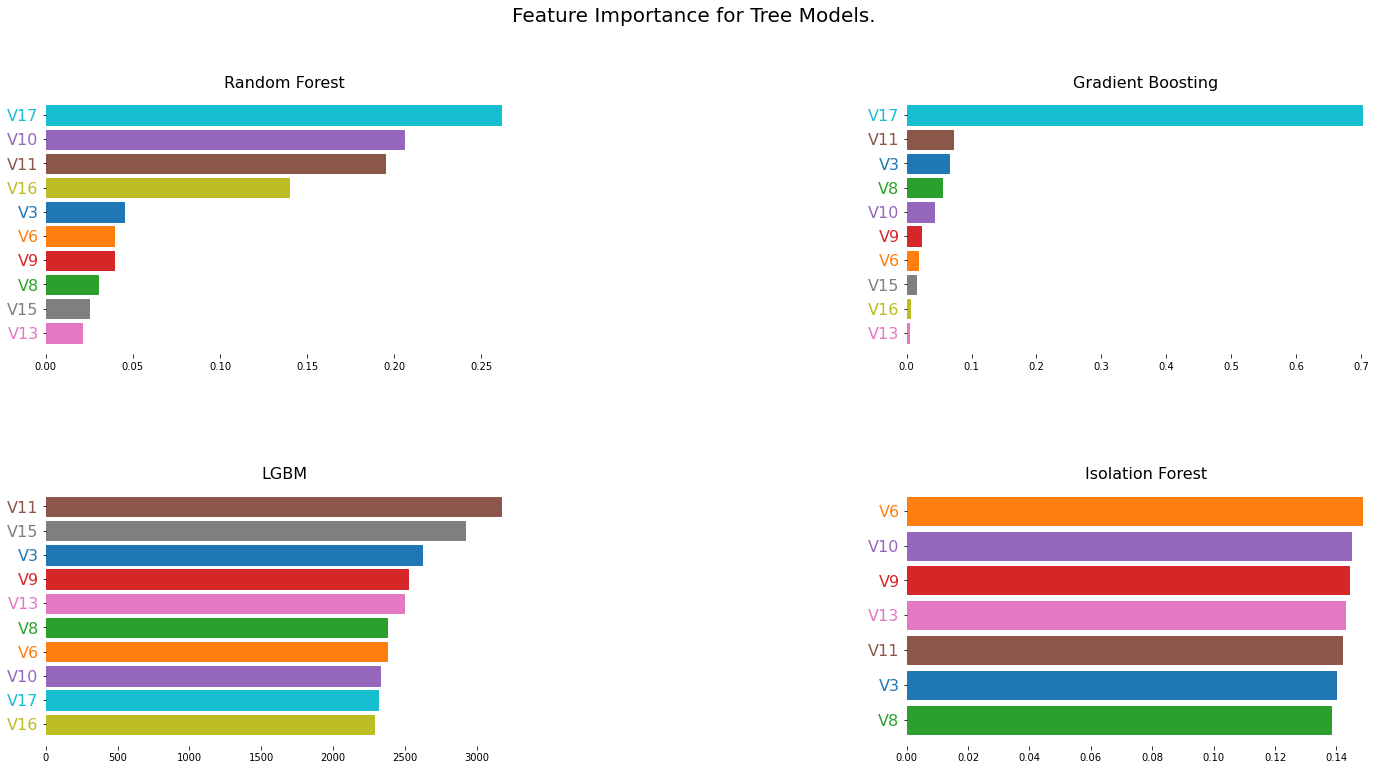

In [300]:
# Create array of tree based models and plot feature importance scores
tree_models = []
#setup_plot()
top_x = 11  # number of x most important features to show
for model in trained_models:
    if hasattr(model["model"]["clf"], "feature_importances_"):
        tree_models.append({"name": model["name"], "fi": model["model"]["clf"].feature_importances_})
        
tree_models=tree_models[:4]
fig, axs = plt.subplots(2, 2, figsize=(24, 12), facecolor="w", edgecolor="k")
fig.subplots_adjust(hspace=0.5, wspace=0.8)
axs = axs.ravel()
for i in range(len(tree_models)):
    feature_importance = tree_models[i]["fi"]
    indices = np.argsort(feature_importance)
    indices = indices[-top_x:]

    bars = axs[i].barh(
        range(len(indices)), feature_importance[indices], color="b", align="center"
    )
    axs[i].set_title(tree_models[i]["name"], fontweight="normal", fontsize=16)

    plt.sca(axs[i])
    plt.yticks(
        range(len(indices)),
        [current_data.columns[j] for j in indices],
        fontweight="normal",
        fontsize=16,
    )

    # print(len(plt.gca().get_yticklabels()), len(indices))
    for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
        ticklabel.set_color(color_list[indices[i]])

    for i, bar in enumerate(bars):
        bar.set_color(color_list[indices[i]])
    plt.box(False)

plt.suptitle(
    "Feature Importance for Tree Models.",
    fontsize=20,
    fontweight="normal",
)
plt.savefig("exp2.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

# Global Explanations via Permutation Feature Importance Scores [Tree Based Models]

Permutation feature importance work by evaluating how much the model's performance decreases when the values of a specific feature are randomly shuffled, effectively breaking the relationship between that feature and the target variable. The decrease in model performance after shuffling indicates the importance of the feature: the larger the decrease, the more important the feature is considered. 

This method is advantageous because it provides a model-agnostic way to interpret feature importance, meaning it can be applied to any machine learning algorithm regardless of its complexity or type (e.g., regression, classification). It also mitigates issues related to multicollinearity and captures non-linear relationships between features and the target variable, making it a versatile tool for understanding model behavior and aiding in feature selection and engineering tasks. Moreover, permutation feature importance is computationally efficient compared to other methods like SHAP values, especially when dealing with large datasets or complex models, making it suitable for practical applications in data science and machine learning.

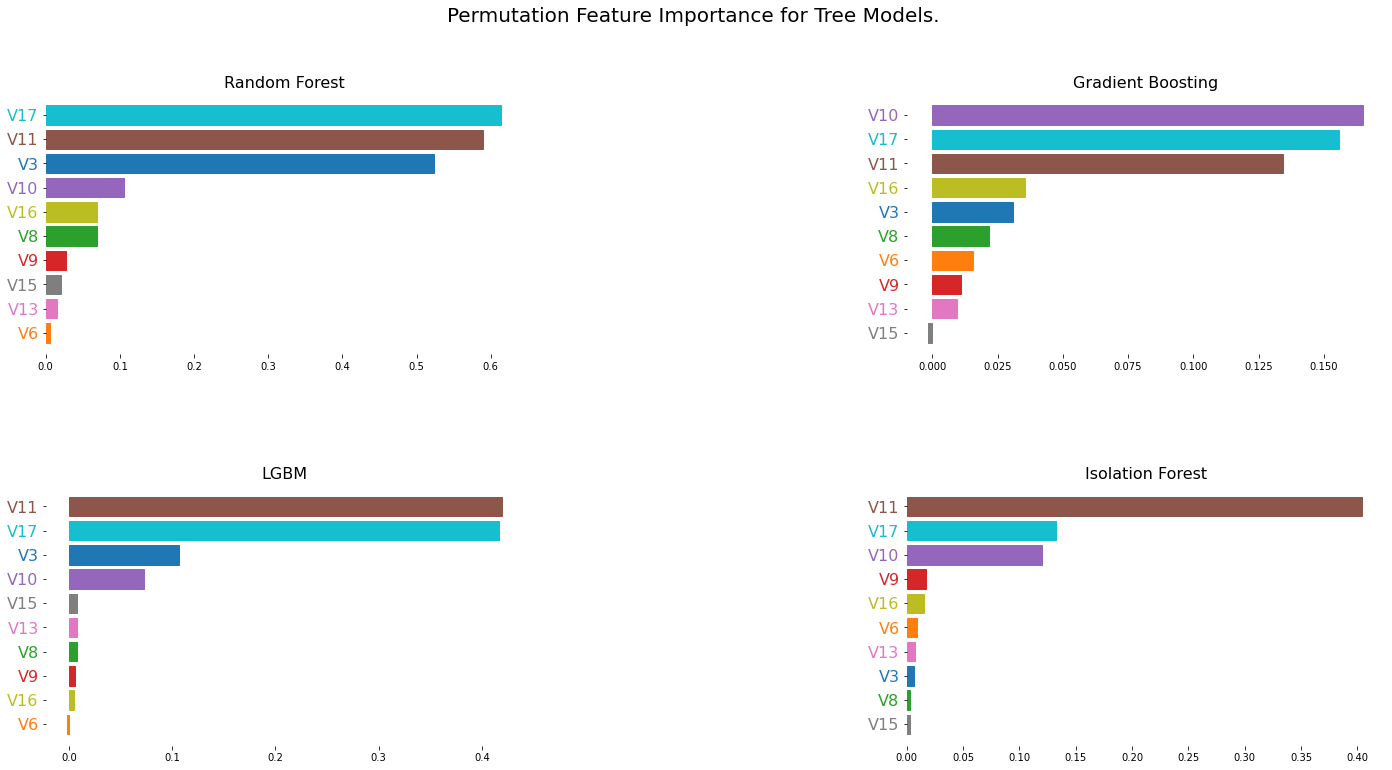

In [301]:
from sklearn.inspection import permutation_importance
Modls=[ DecisionTreeClassifier(), RandomForestClassifier(criterion='entropy', max_features=0.31096155614096943,
        max_leaf_nodes=161, n_estimators=12, n_jobs=-1), GradientBoostingClassifier(n_estimators=100),LGBMClassifier(learning_rate=0.054035619656969944, max_bin=511,
               min_child_samples=11, n_estimators=1360, num_leaves=44,
               reg_alpha=0.002947632445703634, reg_lambda=0.01268422625516522,
               verbose=-1)]
for model in Modls:
    model.fit(X_train,y_train)
    
Perm_I=[]
for  model in Modls:
    perm = permutation_importance(model, X_test,y_test,scoring= "r2",n_repeats=5, random_state=0)
    Perm_I.append(perm.importances_mean)
    
# Create array of tree based models and plot feature importance scores
tree_models = []
#setup_plot()
top_x = 11  # number of x most important features to show
for model in trained_models:
    if hasattr(model["model"]["clf"], "feature_importances_"):
        tree_models.append({"name": model["name"], "fi": model["model"]["clf"].feature_importances_})
for i in range(len(Perm_I)):
    tree_models[i]['fi']=Perm_I[i]       
tree_models=tree_models[:4]
fig, axs = plt.subplots(2, 2, figsize=(24, 12), facecolor="w", edgecolor="k")
fig.subplots_adjust(hspace=0.5, wspace=0.8)
axs = axs.ravel()
for i in range(len(tree_models)):
    feature_importance = tree_models[i]["fi"]
    indices = np.argsort(feature_importance)
    indices = indices[-top_x:]

    bars = axs[i].barh(
        range(len(indices)), feature_importance[indices], color="b", align="center"
    )
    axs[i].set_title(tree_models[i]["name"], fontweight="normal", fontsize=16)

    plt.sca(axs[i])
    plt.yticks(
        range(len(indices)),
        [current_data.columns[j] for j in indices],
        fontweight="normal",
        fontsize=16,
    )

    # print(len(plt.gca().get_yticklabels()), len(indices))
    for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
        ticklabel.set_color(color_list[indices[i]])

    for i, bar in enumerate(bars):
        bar.set_color(color_list[indices[i]])
    plt.box(False)

plt.suptitle(
    "Permutation Feature Importance for Tree Models.",
    fontsize=20,
    fontweight="normal",
)

plt.savefig("exp3.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()


# Explanations with LIME

Local Interpretable Model-agnostic Explanation (LIME) provides a fast and relatively simple method for locally explaining black box models. The LIME algorithm can be simplified into a few steps

1. For a given data point, randomly perturb its features repeatedly. For tabular data, this entails adding a small amount of noise to each feature.

2. Get predictions for each perturbed data instance. This helps us build up a local picture of the decision surface at that point.
3. Use predictions to compute an approximate linear "explanation model" using predictions. Coefficients of the linear model are used as explanations.

The LIME python library provides interfaces for explaining models built on tabular (TabularExplainer), image (LimeImageExplainer), and text data (LimeTextExplainer).

In the following section, we will attempt to explain predictions from a single test data instance for all our trained models using the LimeTabularExplainer.

## LIME Tabular Explainer: Explain a test data instance for all models

In the following section, we will generate and visualize lime explanations for a given data point in our test set. We will do this for all our trained models.


In [302]:
train_models=trained_models
X_train, X_test, y_train, y_test = train_test_split(
    current_data, labels, random_state=42
)


def get_lime_explainer(model, data, labels):
    cat_feat_ix = [
        i
        for i, c in enumerate(data.columns)
        if pd.api.types.is_categorical_dtype(data[c])
    ]
    feat_names = list(data.columns)
    class_names = list(labels.unique())
    scaler = model["model"]["scaler"]
    data = scaler.transform(data)  # scale data to reflect train time scaling
    lime_explainer = LimeTabularExplainer(
        data,
        feature_names=feat_names,
        class_names=class_names,
        categorical_features=cat_feat_ix,
        mode="classification",
    )
    return lime_explainer


def lime_explain(explainer, data, predict_method, num_features):
    explanation = explainer.explain_instance(
        data, predict_method, num_features=num_features
    )
    return explanation


lime_data_explainations = []
lime_metrics = []
lime_explanation_time = []
feat_names = list(current_data.columns)
test_data_index = 6
for current_model in trained_models:
    scaler = current_model["model"]["scaler"]
    scaled_test_data = scaler.transform(X_test)
    predict_method = current_model["model"]["clf"].predict_proba

    start_time = time.time()
    # explain first sample from test data
    lime_explainer = get_lime_explainer(current_model, X_train, y_train)
    explanation = lime_explain(
        lime_explainer, scaled_test_data[test_data_index], predict_method, top_x
    )
    elapsed_time = time.time() - start_time

    ex_holder = {}
    for feat_index, ex in explanation.as_map()[1]:
        ex_holder[feat_names[feat_index]] = ex

    lime_data_explainations.append(ex_holder)
    actual_pred = predict_method(scaled_test_data[test_data_index].reshape(1, -1))
    perc_pred_diff = abs(actual_pred[0][1] - explanation.local_pred[0])
    lime_explanation_time.append({"time": elapsed_time, "model": current_model["name"]})
    lime_metrics.append(
        {
            "lime class1": explanation.local_pred[0],
            "actual class1": actual_pred[0][1],
            "class_diff": round(perc_pred_diff, 3),
            "model": current_model["name"],
        }
    )


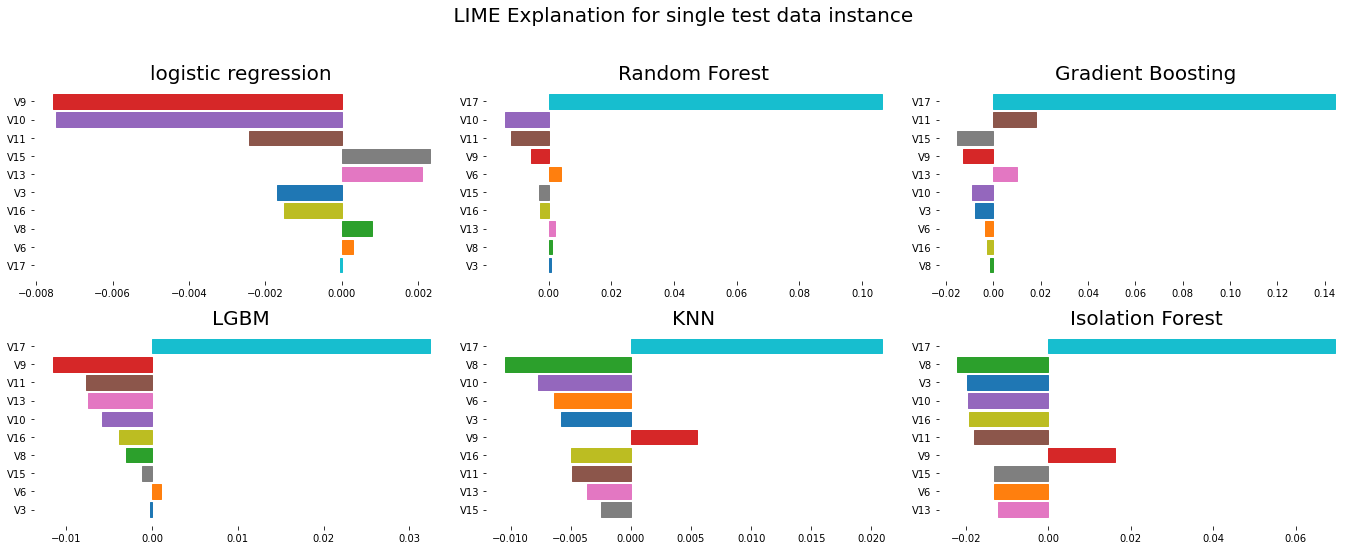

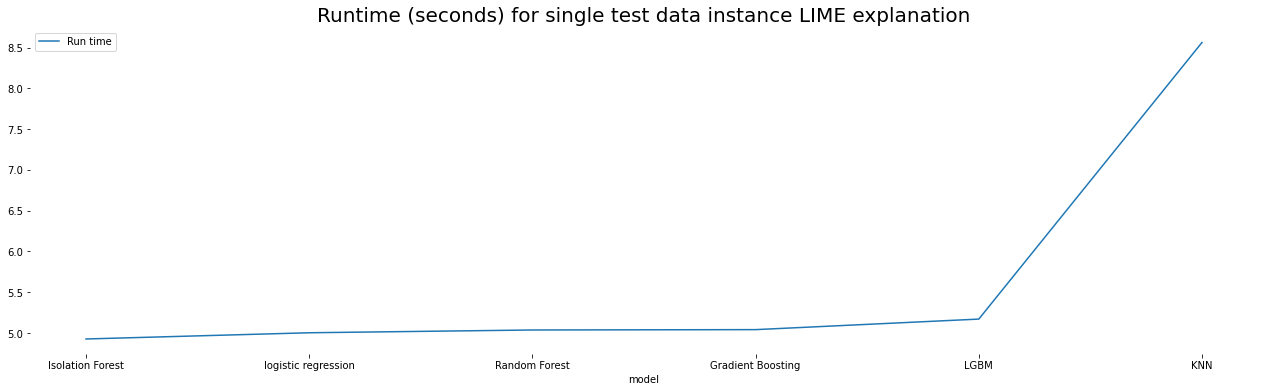

In [303]:
def plot_lime_exp(fig, fig_index, exp_data, title):
    features = list(exp_data.keys())[::-1]
    explanations = list(exp_data.values())[::-1]
    ax = fig.add_subplot(int(fig_index))
    lime_bar = ax.barh(features, explanations)
    ax.set_title(title, fontsize=20)
    for i, bar in enumerate(lime_bar):
        bar.set_color(color_list[list(current_data.columns).index(features[i])])
        plt.box(False)
fig = plt.figure(figsize=(19, 8))
lime_data_explainations=lime_data_explainations[:6]
# Plot lime explanations for trained models
for i, dex in enumerate(lime_data_explainations):
    fig_index = "23" + str(i + 1)
    plot_lime_exp(fig, fig_index, lime_data_explainations[i], trained_models[i]["name"])

plt.suptitle(
    " LIME Explanation for single test data instance",
    fontsize=20,
    fontweight="normal",
)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("exp4.pdf", format="pdf", bbox_inches="tight",dpi=1000)
# Plot run time for explanations
lx_df = pd.DataFrame(lime_explanation_time)
lx_df.sort_values("time", inplace=True)
lx_ax = lx_df.plot(
    kind="line",
    x="model",
    title="Runtime (seconds) for single test data instance LIME explanation",
    figsize=(22, 6),
)
lx_ax.title.set_size(20)
lx_ax.legend(["Run time"])
plt.box(False)
plt.savefig("exp5.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()


# Debugging LIME: Should I trust the Explanation?

Underneath, the LIME algorithm uses an approximate linear model to derive local explanations. Like any other ML model, this explanation model can have issues too. So, what can we do to build confidence in the quality of an explanation. As a first step, we can check if the local model is indeed a good approximator for the original model.


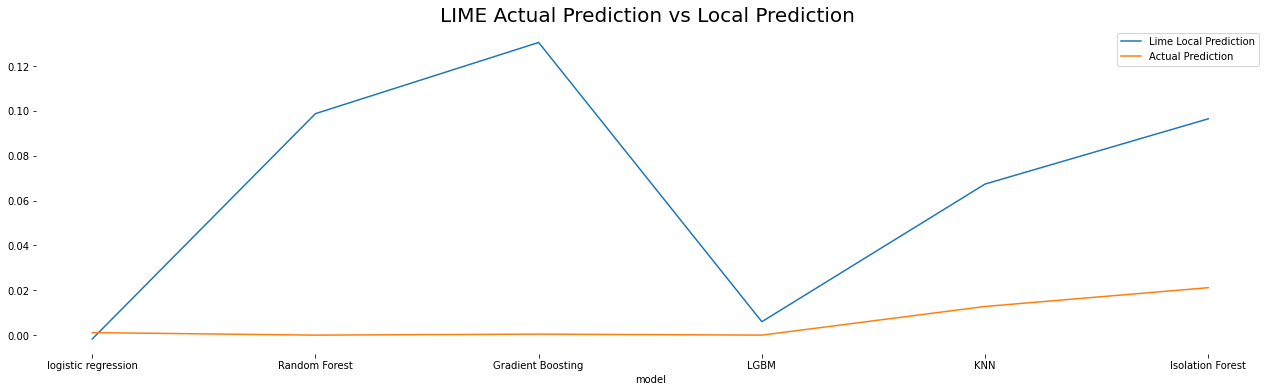

In [304]:
# Plot run time for explanations
lime_metrics_df = pd.DataFrame(lime_metrics)
lime_metrics_df_ax = lime_metrics_df[["lime class1", "actual class1", "model"]].plot(
    kind="line",
    x="model",
    title="LIME Actual Prediction vs Local Prediction ",
    figsize=(22, 6),
)
lime_metrics_df_ax.title.set_size(20)
lime_metrics_df_ax.legend(["Lime Local Prediction", "Actual Prediction"])
plt.box(False)
plt.savefig("exp6.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

The plot above shows the predictions made by the LIME local model and the original model for the explained data instance. Both numbers should be close. When they are not, this may raise questions as to if we can trust the explanation. There are few things that can be done:

   1. Modify the parameters of LIME to yield a better explanation. E.g. increase the number of perturbations (LIME ) or kernel width (see related discussion here),
   2. Improve our original model (In this case, we know that the Decision Tree shows signs of overfitting).
   
   
   
Overall, this visualization  helps in understanding how LIME interprets the predictions of various machine learning models locally and compares them with the actual model predictions. It provides insights into the consistency and accuracy of LIME explanations across different model configurations.

The next explanation method we will consider (SHAP) aims to address such inconsistencies. Let's go!


# Explanations with SHAP

SHAP (SHapley Additive exPlanations) is a versatile framework in machine learning for interpreting model predictions. It leverages concepts from cooperative game theory to attribute the contribution of each feature to individual predictions. This approach provides both local interpretability, explaining why a particular prediction was made for a specific instance, and global insights into feature importance across the entire dataset. By calculating SHAP values, which satisfy the additivity property, SHAP offers accurate and intuitive explanations for complex machine learning models, regardless of their type or architecture.

The advantages of SHAP lie in its model-agnostic nature, making it applicable to a wide range of machine learning models, from traditional tree-based methods to modern deep neural networks. SHAP values not only enhance model transparency and trust by elucidating how each feature influences predictions, but they also aid in feature selection, model debugging, and diagnosing biases. Ultimately, SHAP empowers stakeholders to make informed decisions based on model predictions, fostering greater understanding and acceptance of machine learning systems in real-world applications.

### The SHAP Library Implementation.

The SHAP library contains implementations for several types of explanations that leverage Shapley values. These include the TreeExplainer which is optimized (and fast) for tree based models; DeepExplainer and GradientExplainer for neural networks; and KernelExplainer, which makes no assumptions about the underlying model to be explained (model agnostic like LIME).


## Kernel Explainer

In [305]:
current_model = trained_models[3]  # Explain the Random Forest Model
clf = current_model["model"]["clf"]
scaler = current_model["model"]["scaler"]
scaled_train_data = scaler.transform(X_train)
sub_sampled_train_data = shap.sample(
    scaled_train_data, 600, random_state=0
)  # use 600 samples of train data as background data

scaled_test_data = scaler.transform(X_test)
subsampled_test_data = scaled_test_data[test_data_index].reshape(1, -1)

start_time = time.time()
explainer = shap.KernelExplainer(clf.predict_proba, sub_sampled_train_data)
shap_values = explainer.shap_values(subsampled_test_data, l1_reg="aic")
elapsed_time = time.time() - start_time

# explain first sample from test data
print(
    "Kernel Explainer SHAP run time",
    round(elapsed_time, 3),
    " seconds. ",
    current_model["name"],
)
print("SHAP expected value", explainer.expected_value)
print("Model mean value", clf.predict_proba(scaled_train_data).mean(axis=0))
print("Model prediction for test data", clf.predict_proba(subsampled_test_data))
shap.initjs()
pred_ind = 0
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][0],
    subsampled_test_data[0],
    feature_names=X_train.columns,
)

Using 600 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Kernel Explainer SHAP run time 20.339  seconds.  LGBM
SHAP expected value [0.98833346 0.01166654]
Model mean value [0.99037331 0.00962669]
Model prediction for test data [[9.99999997e-01 3.10437833e-09]]


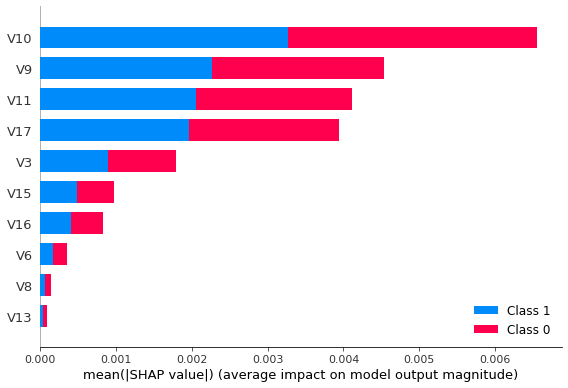

<Figure size 432x288 with 0 Axes>

In [306]:
shap.initjs()
shap.summary_plot(
    shap_values, subsampled_test_data, feature_names=X_train.columns, max_display=10
)
plt.savefig("exp8.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

# Tree Explainer


In [307]:
current_model = trained_models[3]
clf = current_model["model"]["clf"]
scaler = current_model["model"]["scaler"]

scaled_test_data = scaler.transform(X_test)
subsampled_test_data = scaled_test_data[test_data_index].reshape(1, -1)

# explain first sample from test data
start_time = time.time()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(subsampled_test_data)
elapsed_time = time.time() - start_time

print(
    "Tree Explainer SHAP run time",
    round(elapsed_time, 3),
    " seconds. ",
    current_model["name"],
)
print("SHAP expected value", explainer.expected_value)
print("Model mean value", clf.predict_proba(scaled_train_data).mean(axis=0))
print("Model prediction for test data", clf.predict_proba(subsampled_test_data))
shap.initjs()
pred_ind = 0
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][0],
    subsampled_test_data[0],
    feature_names=X_train.columns,
)

Tree Explainer SHAP run time 0.998  seconds.  LGBM
SHAP expected value [15.671676787422571, -15.671676787422571]
Model mean value [0.99037331 0.00962669]
Model prediction for test data [[9.99999997e-01 3.10437833e-09]]



# Kernel Explainer - Explain a test data instance for all models

In the following section, we will generate and visualize explanations using the SHAP KernelExplainer for a given data point in our test set (same as we did for LIME).


In [308]:
def get_kernel_shap_explainer(model, background_data, train_data):
    shap_explainer = shap.KernelExplainer(model.predict_proba, background_data)
    return shap_explainer


def shap_explain(explainer, test_data):
    shap_values = explainer.shap_values(test_data, l1_reg="aic")
    return shap_values


shap_data_explainations = []
shape_explanation_time = []
feat_names = list(current_data.columns)
data_subsample = 500

for current_model in trained_models:
    scaler = current_model["model"]["scaler"]
    scaled_test_data = scaler.transform(X_test)
    scaled_train_data = scaler.transform(X_train)
    sampled_scaled_train_data = shap.sample(
        scaled_train_data, data_subsample
    )  # subsample background data to make things faster

    start_time = time.time()
    shap_explainer = get_kernel_shap_explainer(
        current_model["model"]["clf"], sampled_scaled_train_data, scaled_train_data
    )

    # explain first sample from test data
    sampled_scaled_test_data = scaled_test_data[test_data_index].reshape(1, -1)
    shap_values = shap_explain(shap_explainer, sampled_scaled_test_data)
    elapsed_time = time.time() - start_time
    idx = np.argsort(np.abs(shap_values[1][0]))[::-1]
    ex_holder = {feat_names[idx[i]]: shap_values[1][0][idx[i]] for i in range(top_x-1)}

    shap_data_explainations.append(ex_holder)
    shape_explanation_time.append(
        {"time": elapsed_time, "model": current_model["name"]}
    )

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

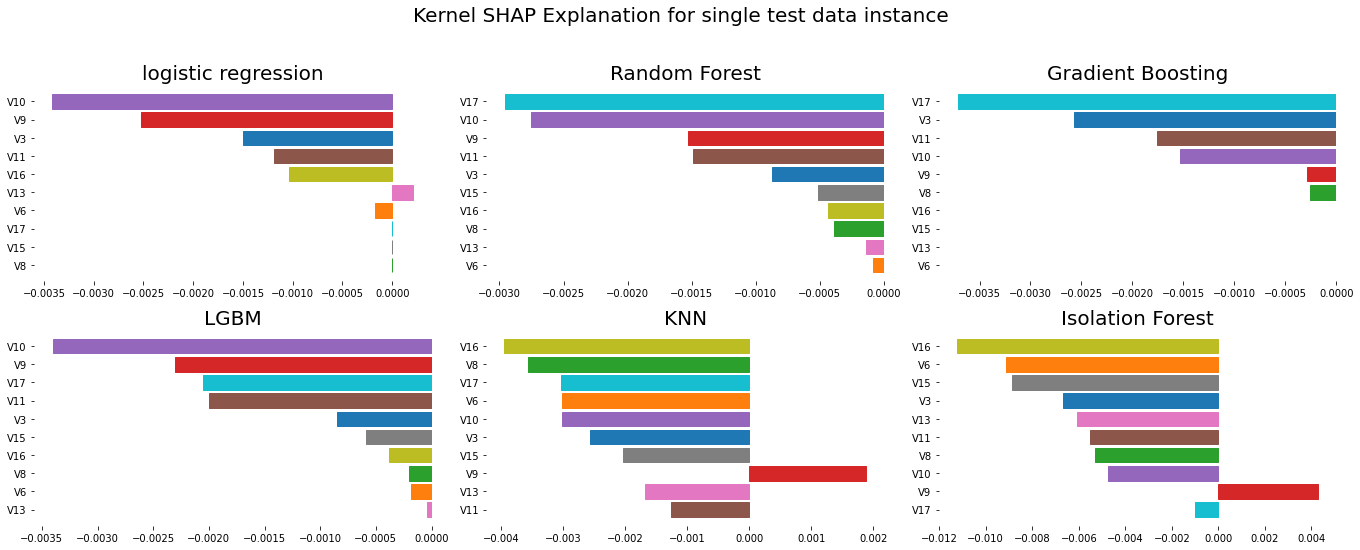

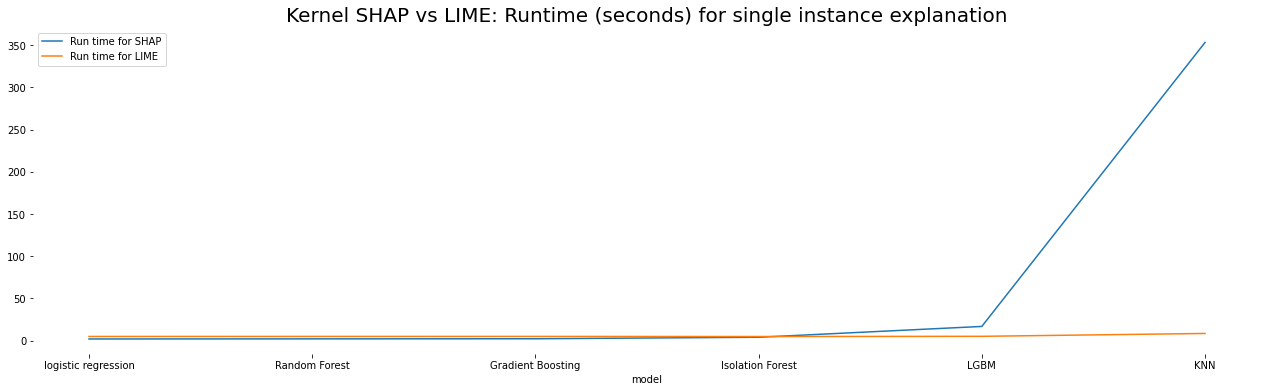

In [309]:
def plot_shap_exp(fig, fig_index, exp_data, title):
    features = list(exp_data.keys())[::-1]
    explanations = list(exp_data.values())[::-1]
    ax = fig.add_subplot(int(fig_index))
    lime_bar = ax.barh(features, explanations)
    ax.set_title(title, fontsize=20)
    for i, bar in enumerate(lime_bar):
        bar.set_color(color_list[list(current_data.columns).index(features[i])])
        plt.box(False)

shap_data_explainations=shap_data_explainations[:6]
# Plot SHAP explanations for a given test set item
fig = plt.figure(figsize=(19, 8))
for i, dex in enumerate(shap_data_explainations):
    fig_index = "23" + str(i + 1)
    plot_lime_exp(fig, fig_index, shap_data_explainations[i], trained_models[i]["name"])

plt.suptitle(
    "Kernel SHAP Explanation for single test data instance",
    fontsize=20,
    fontweight="normal",
)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("exp9.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()
# Plot SHAP explanation run time
shapx_df = pd.DataFrame(shape_explanation_time)
shapx_df.sort_values("time", inplace=True)


# Plot both LIME and SHAP explanation run times
m_df = shapx_df.merge(lx_df, on="model", suffixes=("_SHAP", "_LIME"))
m_df.head()
mx_df_ax = m_df.plot(
    kind="line",
    x="model",
    title="Kernel SHAP vs LIME: Runtime (seconds) for single instance explanation",
    figsize=(22, 6),
)
mx_df_ax.title.set_size(20)
mx_df_ax.legend(["Run time for SHAP", "Run time for LIME"])
plt.box(False)
plt.savefig("exp10.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

## Debugging SHAP KernelExplainer: Small background Dataset may lead to inconsistent expected value.

The process used by SHAP to simulate missing values draws from a background dataset (usually the training set). When the training dataset is large, the authors of SHAP suggest the use of a subsample of the training set as background data to reduce computation costs. A side effect of using a small sub sample is that the expected value used by SHAP may differ from the model's mean value. The plots below compare the SHAP expected value and model mean prediction on training set for multiple background sample sizes.

    1. Run time increases (linearly) with increase in size of background dataset
    
    2. Expected value is closer to mean value on enter train set as the size of background subsample increases. 

The above results raise some questions as to the quality of explanations when a subsample is used as background data for SHAP. It is important to note that the TreeExplainer sidesteps this issue as it does not require a background dataset. Per the SHAP documentation

In [310]:
current_model = trained_models[3]
clf = current_model["model"]["clf"]
scaler = current_model["model"]["scaler"]

sample_sizes = [50, 100, 150, 200, 300, 600, 1000, 2000, 3000]
metric_holder = []


for sample_size in sample_sizes:
    scaled_train_data = scaler.transform(X_train)
    sub_sampled_train_data = shap.sample(
        scaled_train_data, sample_size, random_state=0
    )  # use x samples of train data as background data

    scaled_test_data = scaler.transform(X_test)
    test_data_index = 10
    subsampled_test_data = scaled_test_data[test_data_index].reshape(1, -1)

    start_time = time.time()
    explainer = shap.KernelExplainer(clf.predict_proba, sub_sampled_train_data)
    shap_values = explainer.shap_values(subsampled_test_data, l1_reg="aic")
    elapsed_time = time.time() - start_time

    metric_holder.append(
        {
            "class0 exp": explainer.expected_value[0],
            "class1 exp": explainer.expected_value[1],
            "run time": elapsed_time,
            "sample size": sample_size,
        }
    )

metric_df = pd.DataFrame(metric_holder)

mean_pred = clf.predict_proba(scaled_train_data).mean(axis=0)
metric_df["mean prediction class0"] = mean_pred[0]
metric_df["mean prediction class1"] = mean_pred[1]
metric_df.head()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 600 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 2000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 3000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

,class0 exp,class1 exp,run time,sample size,mean prediction class0,mean prediction class1
0,0.999995,0.000005,2.001129,50,0.990373,0.009627
1,0.999997,0.000003,3.631714,100,0.990373,0.009627
2,0.979998,0.020002,5.634353,150,0.990373,0.009627
3,0.974999,0.025001,7.311719,200,0.990373,0.009627
4,0.983332,0.016668,11.106735,300,0.990373,0.009627


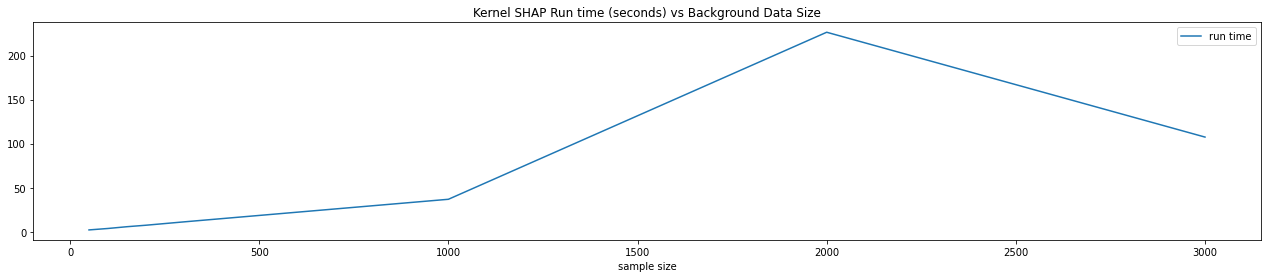

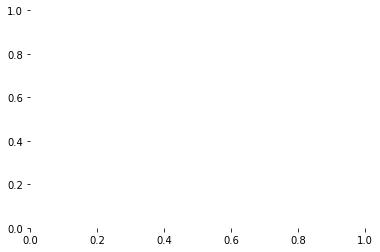

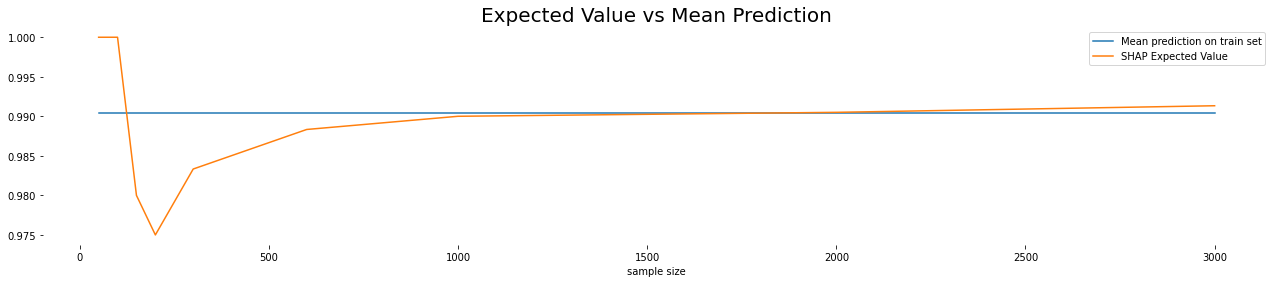

In [311]:
metrix_ax = metric_df[["sample size", "run time"]].plot(
    kind="line",
    x="sample size",
    title="Kernel SHAP Run time (seconds) vs Background Data Size",
    figsize=(22, 4),
)
plt.savefig("exp12.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()
metrix_ax.title.set_size(20)
plt.box(False)
metrix_ax = metric_df[["sample size", "mean prediction class0", "class0 exp"]].plot(
    kind="line",
    x="sample size",
    title="Expected Value vs Mean Prediction",
    figsize=(22, 4),
)
metrix_ax.title.set_size(20)
metrix_ax.legend(["Mean prediction on train set", "SHAP Expected Value"])
plt.box(False)
plt.savefig("exp13.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

# Further assessments

Next we compare LIME and SHAP explainability of three best algorithms in terms of roc_auc score and time: Gradient Boosting, Isolalation Forest and LGBM at different instances.

1. Where anomaly detectors agree on predictions, do they give rise to similar SHAP value explanations? How about when they disagree?

2. How does missing data impact anomaly detection? Are different anomaly detection algorithms better suited for datasets where there are more missing values?

In [312]:
Modls=[ GradientBoostingClassifier(n_estimators=100),IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=0.7,
      max_samples=0.5, n_estimators=50, n_jobs=1, random_state=None,
      verbose=0),LGBMClassifier(learning_rate=0.054035619656969944, max_bin=511,
               min_child_samples=11, n_estimators=1360, num_leaves=44,
               reg_alpha=0.002947632445703634, reg_lambda=0.01268422625516522,
               verbose=-1)]
for model in Modls:
    model.fit(X_train,y_train)

In [377]:
pred_GB=Modls[0].predict(X_test)
pred_IF=Modls[1].predict(X_test)
pred_LGBM=Modls[2].predict(X_test)

In [314]:
Agree_all=[]
Agree_GB_IF=[]
Agree_GB_LGBM=[]
Agree_IF_LGBM=[]
Agree_GB=[]
Agree_IF=[]
Agree_LGBM=[]
for i in range(len(pred_knn)):
    if pred_GB[i]==1 and pred_IF[i]==1 and pred_LGBM[i]==1 and y_test.values[i]==1:
        Agree_all.append(i)
    elif pred_GB[i]==1 and pred_IF[i]==1 and pred_LGBM[i]==0 and y_test.values[i]==1:
        Agree_GB_IF.append(i)
    elif pred_GB[i]==1 and pred_IF[i]==0 and pred_LGBM[i]==1 and y_test.values[i]==1:
        Agree_GB_LGBM.append(i)
    elif pred_GB[i]==0 and pred_IF[i]==1 and pred_LGBM[i]==1 and y_test.values[i]==1:
        Agree_IF_LGBM.append(i)
    elif pred_GB[i]==1 and pred_IF[i]==0 and pred_LGBM[i]==0 and y_test.values[i]==1:
        Agree_GB.append(i)
    elif pred_GB[i]==0 and pred_IF[i]==1 and pred_LGBM[i]==0 and y_test.values[i]==1:
        Agree_IF.append(i)
    elif pred_GB[i]==0 and pred_IF[i]==0 and pred_LGBM[i]==1 and y_test.values[i]==1:
        Agree_LGBM.append(i)    

In [315]:
len(Agree_all),len(Agree_GB_IF), len(Agree_GB_LGBM), len(Agree_IF_LGBM),len(Agree_GB), len(Agree_IF), len(Agree_LGBM)

(86, 1, 0, 5, 0, 3, 0)

In [316]:
X_test_all=X_test.iloc[Agree_all]
X_test_GB_IF=X_test.iloc[Agree_GB_IF]
X_test_IF_LGBM=X_test.iloc[Agree_IF_LGBM]

# LIME

## (a) Case where all the three models agree in correctly predicting fraudulent transactions

In [317]:
ind=[2,3,5]
trained_models=[trained_models[i] for i in ind]

In [427]:
X_train, X_test, y_train, y_test = train_test_split(
    current_data, labels, random_state=42
)

X_test=X_test_all

def get_lime_explainer(model, data, labels):
    cat_feat_ix = [
        i
        for i, c in enumerate(data.columns)
        if pd.api.types.is_categorical_dtype(data[c])
    ]
    feat_names = list(data.columns)
    class_names = list(labels.unique())
    scaler = model["model"]["scaler"]
    data = scaler.transform(data)  # scale data to reflect train time scaling
    lime_explainer = LimeTabularExplainer(
        data,
        feature_names=feat_names,
        class_names=class_names,
        categorical_features=cat_feat_ix,
        mode="classification",
    )
    return lime_explainer


def lime_explain(explainer, data, predict_method, num_features):
    explanation = explainer.explain_instance(
        data, predict_method, num_features=num_features
    )
    return explanation


lime_data_explainations = []
lime_metrics = []
lime_explanation_time = []
feat_names = list(current_data.columns)
test_data_index = 10
for current_model in trained_models:
    scaler = current_model["model"]["scaler"]
    scaled_test_data = scaler.transform(X_test)
    predict_method = current_model["model"]["clf"].predict_proba

    start_time = time.time()
    # explain first sample from test data
    lime_explainer = get_lime_explainer(current_model, X_train, y_train)
    explanation = lime_explain(
        lime_explainer, scaled_test_data[test_data_index], predict_method, top_x
    )
    elapsed_time = time.time() - start_time

    ex_holder = {}
    for feat_index, ex in explanation.as_map()[1]:
        ex_holder[feat_names[feat_index]] = ex

    lime_data_explainations.append(ex_holder)
    actual_pred = predict_method(scaled_test_data[test_data_index].reshape(1, -1))
    perc_pred_diff = abs(actual_pred[0][1] - explanation.local_pred[0])
    lime_explanation_time.append({"time": elapsed_time, "model": current_model["name"]})
    lime_metrics.append(
        {
            "lime class1": explanation.local_pred[0],
            "actual class1": actual_pred[0][1],
            "class_diff": round(perc_pred_diff, 3),
            "model": current_model["name"],
        }
    )


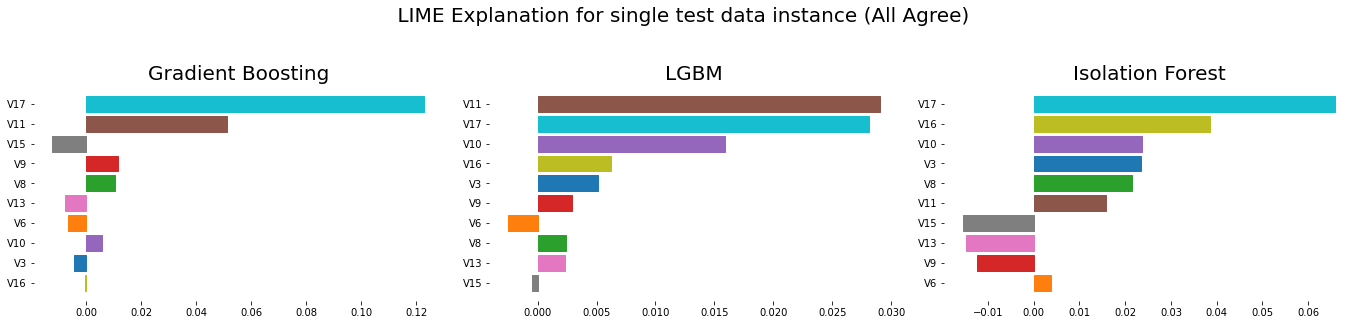

In [319]:
def plot_lime_exp(fig, fig_index, exp_data, title):
    features = list(exp_data.keys())[::-1]
    explanations = list(exp_data.values())[::-1]
    ax = fig.add_subplot(int(fig_index))
    lime_bar = ax.barh(features, explanations)
    ax.set_title(title, fontsize=20)
    for i, bar in enumerate(lime_bar):
        bar.set_color(color_list[list(current_data.columns).index(features[i])])
        plt.box(False)
fig = plt.figure(figsize=(19, 8))
lime_data_explainations
# Plot lime explanations for trained models
for i, dex in enumerate(lime_data_explainations):
    fig_index = "23" + str(i + 1)
    plot_lime_exp(fig, fig_index, lime_data_explainations[i], trained_models[i]["name"])

plt.suptitle(
    " LIME Explanation for single test data instance (All Agree)",
    fontsize=20,
    fontweight="normal",
)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("exp14.pdf", format="pdf", bbox_inches="tight",dpi=1000)

## (b) Case where only Gradient Bosting and Isolation Forest  agree in correctly predicting fraudulent transactions

In [320]:
X_train, X_test, y_train, y_test = train_test_split(
    current_data, labels, random_state=42
)

X_test=X_test_GB_IF

def get_lime_explainer(model, data, labels):
    cat_feat_ix = [
        i
        for i, c in enumerate(data.columns)
        if pd.api.types.is_categorical_dtype(data[c])
    ]
    feat_names = list(data.columns)
    class_names = list(labels.unique())
    scaler = model["model"]["scaler"]
    data = scaler.transform(data)  # scale data to reflect train time scaling
    lime_explainer = LimeTabularExplainer(
        data,
        feature_names=feat_names,
        class_names=class_names,
        categorical_features=cat_feat_ix,
        mode="classification",
    )
    return lime_explainer


def lime_explain(explainer, data, predict_method, num_features):
    explanation = explainer.explain_instance(
        data, predict_method, num_features=num_features
    )
    return explanation
lime_data_explainations = []
lime_metrics = []
lime_explanation_time = []
feat_names = list(current_data.columns)
test_data_index = 0
for current_model in trained_models:
    scaler = current_model["model"]["scaler"]
    scaled_test_data = scaler.transform(X_test)
    predict_method = current_model["model"]["clf"].predict_proba

    start_time = time.time()
    # explain first sample from test data
    lime_explainer = get_lime_explainer(current_model, X_train, y_train)
    explanation = lime_explain(
        lime_explainer, scaled_test_data[test_data_index], predict_method, top_x
    )
    elapsed_time = time.time() - start_time

    ex_holder = {}
    for feat_index, ex in explanation.as_map()[1]:
        ex_holder[feat_names[feat_index]] = ex

    lime_data_explainations.append(ex_holder)
    actual_pred = predict_method(scaled_test_data[test_data_index].reshape(1, -1))
    perc_pred_diff = abs(actual_pred[0][1] - explanation.local_pred[0])
    lime_explanation_time.append({"time": elapsed_time, "model": current_model["name"]})
    lime_metrics.append(
        {
            "lime class1": explanation.local_pred[0],
            "actual class1": actual_pred[0][1],
            "class_diff": round(perc_pred_diff, 3),
            "model": current_model["name"],
        }
    )

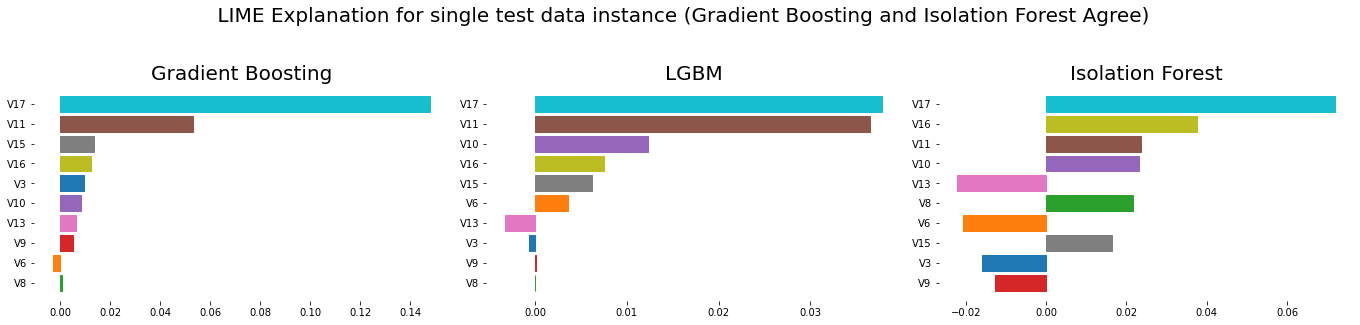

In [321]:
def plot_lime_exp(fig, fig_index, exp_data, title):
    features = list(exp_data.keys())[::-1]
    explanations = list(exp_data.values())[::-1]
    ax = fig.add_subplot(int(fig_index))
    lime_bar = ax.barh(features, explanations)
    ax.set_title(title, fontsize=20)
    for i, bar in enumerate(lime_bar):
        bar.set_color(color_list[list(current_data.columns).index(features[i])])
        plt.box(False)
fig = plt.figure(figsize=(19, 8))
lime_data_explainations
# Plot lime explanations for trained models
for i, dex in enumerate(lime_data_explainations):
    fig_index = "23" + str(i + 1)
    plot_lime_exp(fig, fig_index, lime_data_explainations[i], trained_models[i]["name"])

plt.suptitle(
    " LIME Explanation for single test data instance (Gradient Boosting and Isolation Forest Agree)",
    fontsize=20,
    fontweight="normal",
)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("exp15.pdf", format="pdf", bbox_inches="tight",dpi=1000)

## (c) Case where only Isolation Forest  and LGBM Classifier agree in correctly predicting fraudulent transactions

In [322]:
X_train, X_test, y_train, y_test = train_test_split(
    current_data, labels, random_state=42
)

X_test=X_test_IF_LGBM

def get_lime_explainer(model, data, labels):
    cat_feat_ix = [
        i
        for i, c in enumerate(data.columns)
        if pd.api.types.is_categorical_dtype(data[c])
    ]
    feat_names = list(data.columns)
    class_names = list(labels.unique())
    scaler = model["model"]["scaler"]
    data = scaler.transform(data)  # scale data to reflect train time scaling
    lime_explainer = LimeTabularExplainer(
        data,
        feature_names=feat_names,
        class_names=class_names,
        categorical_features=cat_feat_ix,
        mode="classification",
    )
    return lime_explainer


def lime_explain(explainer, data, predict_method, num_features):
    explanation = explainer.explain_instance(
        data, predict_method, num_features=num_features
    )
    return explanation
lime_data_explainations = []
lime_metrics = []
lime_explanation_time = []
feat_names = list(current_data.columns)
test_data_index = 0
for current_model in trained_models:
    scaler = current_model["model"]["scaler"]
    scaled_test_data = scaler.transform(X_test)
    predict_method = current_model["model"]["clf"].predict_proba

    start_time = time.time()
    # explain first sample from test data
    lime_explainer = get_lime_explainer(current_model, X_train, y_train)
    explanation = lime_explain(
        lime_explainer, scaled_test_data[test_data_index], predict_method, top_x
    )
    elapsed_time = time.time() - start_time

    ex_holder = {}
    for feat_index, ex in explanation.as_map()[1]:
        ex_holder[feat_names[feat_index]] = ex

    lime_data_explainations.append(ex_holder)
    actual_pred = predict_method(scaled_test_data[test_data_index].reshape(1, -1))
    perc_pred_diff = abs(actual_pred[0][1] - explanation.local_pred[0])
    lime_explanation_time.append({"time": elapsed_time, "model": current_model["name"]})
    lime_metrics.append(
        {
            "lime class1": explanation.local_pred[0],
            "actual class1": actual_pred[0][1],
            "class_diff": round(perc_pred_diff, 3),
            "model": current_model["name"],
        }
    )

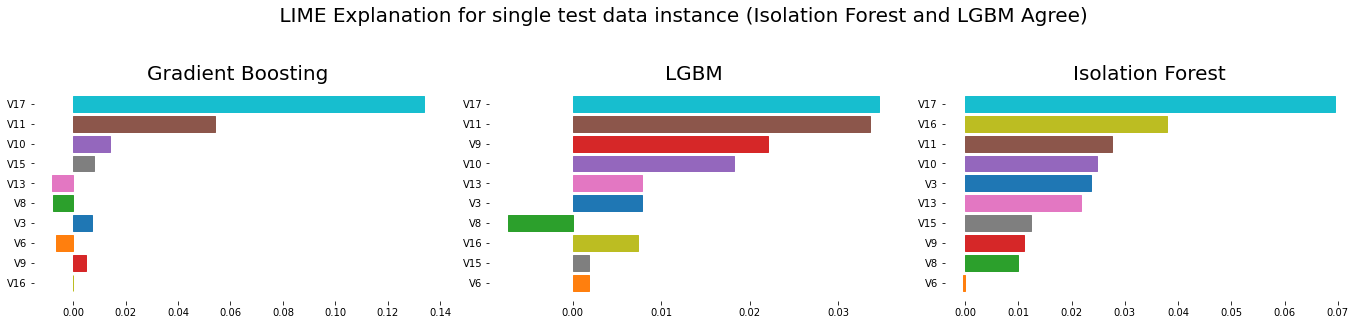

In [323]:
def plot_lime_exp(fig, fig_index, exp_data, title):
    features = list(exp_data.keys())[::-1]
    explanations = list(exp_data.values())[::-1]
    ax = fig.add_subplot(int(fig_index))
    lime_bar = ax.barh(features, explanations)
    ax.set_title(title, fontsize=20)
    for i, bar in enumerate(lime_bar):
        bar.set_color(color_list[list(current_data.columns).index(features[i])])
        plt.box(False)
fig = plt.figure(figsize=(19, 8))
lime_data_explainations
# Plot lime explanations for trained models
for i, dex in enumerate(lime_data_explainations):
    fig_index = "23" + str(i + 1)
    plot_lime_exp(fig, fig_index, lime_data_explainations[i], trained_models[i]["name"])

plt.suptitle(
    " LIME Explanation for single test data instance (Isolation Forest and LGBM Agree)",
    fontsize=20,
    fontweight="normal",
)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("exp16.pdf", format="pdf", bbox_inches="tight",dpi=1000)

# SHAP

## (a) Case where all the three models agree in correctly predicting fraudulent transactions

In [324]:
X_test=X_test_all
def get_kernel_shap_explainer(model, background_data, train_data):
    shap_explainer = shap.KernelExplainer(model.predict_proba, background_data)
    return shap_explainer


def shap_explain(explainer, test_data):
    shap_values = explainer.shap_values(test_data, l1_reg="aic")
    return shap_values


shap_data_explainations = []
shape_explanation_time = []
feat_names = list(current_data.columns)
data_subsample = 500

for current_model in trained_models:
    scaler = current_model["model"]["scaler"]
    scaled_test_data = scaler.transform(X_test)
    scaled_train_data = scaler.transform(X_train)
    sampled_scaled_train_data = shap.sample(
        scaled_train_data, data_subsample
    )  # subsample background data to make things faster

    start_time = time.time()
    shap_explainer = get_kernel_shap_explainer(
        current_model["model"]["clf"], sampled_scaled_train_data, scaled_train_data
    )

    # explain first sample from test data
    sampled_scaled_test_data = scaled_test_data[test_data_index].reshape(1, -1)
    shap_values = shap_explain(shap_explainer, sampled_scaled_test_data)
    elapsed_time = time.time() - start_time
    idx = np.argsort(np.abs(shap_values[1][0]))[::-1]
    ex_holder = {feat_names[idx[i]]: shap_values[1][0][idx[i]] for i in range(top_x-1)}

    shap_data_explainations.append(ex_holder)
    shape_explanation_time.append(
        {"time": elapsed_time, "model": current_model["name"]}
    )

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

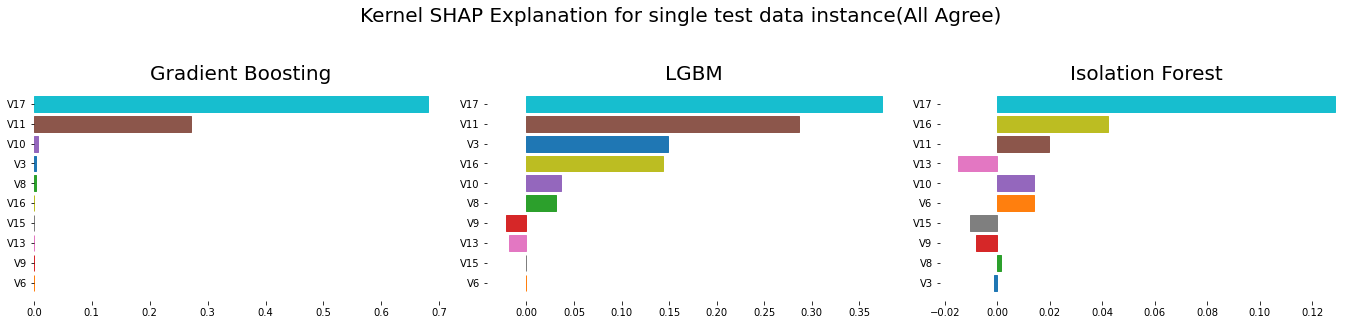

In [325]:
def plot_shap_exp(fig, fig_index, exp_data, title):
    features = list(exp_data.keys())[::-1]
    explanations = list(exp_data.values())[::-1]
    ax = fig.add_subplot(int(fig_index))
    lime_bar = ax.barh(features, explanations)
    ax.set_title(title, fontsize=20)
    for i, bar in enumerate(lime_bar):
        bar.set_color(color_list[list(current_data.columns).index(features[i])])
        plt.box(False)

shap_data_explainations=shap_data_explainations[:6]
# Plot SHAP explanations for a given test set item
fig = plt.figure(figsize=(19, 8))
for i, dex in enumerate(shap_data_explainations):
    fig_index = "23" + str(i + 1)
    plot_lime_exp(fig, fig_index, shap_data_explainations[i], trained_models[i]["name"])

plt.suptitle(
    "Kernel SHAP Explanation for single test data instance(All Agree)",
    fontsize=20,
    fontweight="normal",
)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("exp17.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

## (b) Case where only Gradient Bosting and Isolation Forest  agree in correctly predicting fraudulent transactions

In [326]:
X_test=X_test_GB_IF
def get_kernel_shap_explainer(model, background_data, train_data):
    shap_explainer = shap.KernelExplainer(model.predict_proba, background_data)
    return shap_explainer


def shap_explain(explainer, test_data):
    shap_values = explainer.shap_values(test_data, l1_reg="aic")
    return shap_values


shap_data_explainations = []
shape_explanation_time = []
feat_names = list(current_data.columns)
data_subsample = 500

for current_model in trained_models:
    scaler = current_model["model"]["scaler"]
    scaled_test_data = scaler.transform(X_test)
    scaled_train_data = scaler.transform(X_train)
    sampled_scaled_train_data = shap.sample(
        scaled_train_data, data_subsample
    )  # subsample background data to make things faster

    start_time = time.time()
    shap_explainer = get_kernel_shap_explainer(
        current_model["model"]["clf"], sampled_scaled_train_data, scaled_train_data
    )

    # explain first sample from test data
    sampled_scaled_test_data = scaled_test_data[test_data_index].reshape(1, -1)
    shap_values = shap_explain(shap_explainer, sampled_scaled_test_data)
    elapsed_time = time.time() - start_time
    idx = np.argsort(np.abs(shap_values[1][0]))[::-1]
    ex_holder = {feat_names[idx[i]]: shap_values[1][0][idx[i]] for i in range(top_x-1)}

    shap_data_explainations.append(ex_holder)
    shape_explanation_time.append(
        {"time": elapsed_time, "model": current_model["name"]}
    )

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

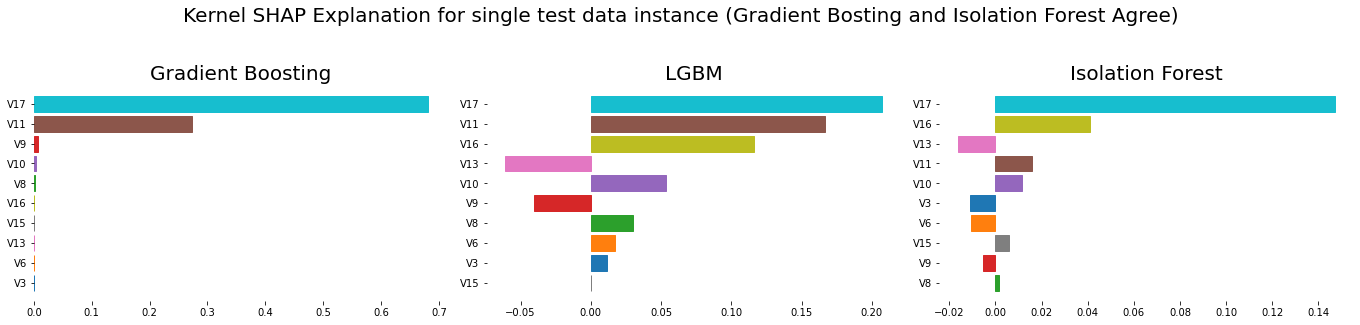

In [327]:
def plot_shap_exp(fig, fig_index, exp_data, title):
    features = list(exp_data.keys())[::-1]
    explanations = list(exp_data.values())[::-1]
    ax = fig.add_subplot(int(fig_index))
    lime_bar = ax.barh(features, explanations)
    ax.set_title(title, fontsize=20)
    for i, bar in enumerate(lime_bar):
        bar.set_color(color_list[list(current_data.columns).index(features[i])])
        plt.box(False)

shap_data_explainations=shap_data_explainations[:6]
# Plot SHAP explanations for a given test set item
fig = plt.figure(figsize=(19, 8))
for i, dex in enumerate(shap_data_explainations):
    fig_index = "23" + str(i + 1)
    plot_lime_exp(fig, fig_index, shap_data_explainations[i], trained_models[i]["name"])

plt.suptitle(
    "Kernel SHAP Explanation for single test data instance (Gradient Bosting and Isolation Forest Agree)",
    fontsize=20,
    fontweight="normal",
)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("exp18.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

## (c) Case where only Isolation Forest  and LGBM Classifier agree in correctly predicting fraudulent transactions

In [328]:
X_test=X_test_IF_LGBM
def get_kernel_shap_explainer(model, background_data, train_data):
    shap_explainer = shap.KernelExplainer(model.predict_proba, background_data)
    return shap_explainer


def shap_explain(explainer, test_data):
    shap_values = explainer.shap_values(test_data, l1_reg="aic")
    return shap_values


shap_data_explainations = []
shape_explanation_time = []
feat_names = list(current_data.columns)
data_subsample = 500

for current_model in trained_models:
    scaler = current_model["model"]["scaler"]
    scaled_test_data = scaler.transform(X_test)
    scaled_train_data = scaler.transform(X_train)
    sampled_scaled_train_data = shap.sample(
        scaled_train_data, data_subsample
    )  # subsample background data to make things faster

    start_time = time.time()
    shap_explainer = get_kernel_shap_explainer(
        current_model["model"]["clf"], sampled_scaled_train_data, scaled_train_data
    )

    # explain first sample from test data
    sampled_scaled_test_data = scaled_test_data[test_data_index].reshape(1, -1)
    shap_values = shap_explain(shap_explainer, sampled_scaled_test_data)
    elapsed_time = time.time() - start_time
    idx = np.argsort(np.abs(shap_values[1][0]))[::-1]
    ex_holder = {feat_names[idx[i]]: shap_values[1][0][idx[i]] for i in range(top_x-1)}

    shap_data_explainations.append(ex_holder)
    shape_explanation_time.append(
        {"time": elapsed_time, "model": current_model["name"]}
    )

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

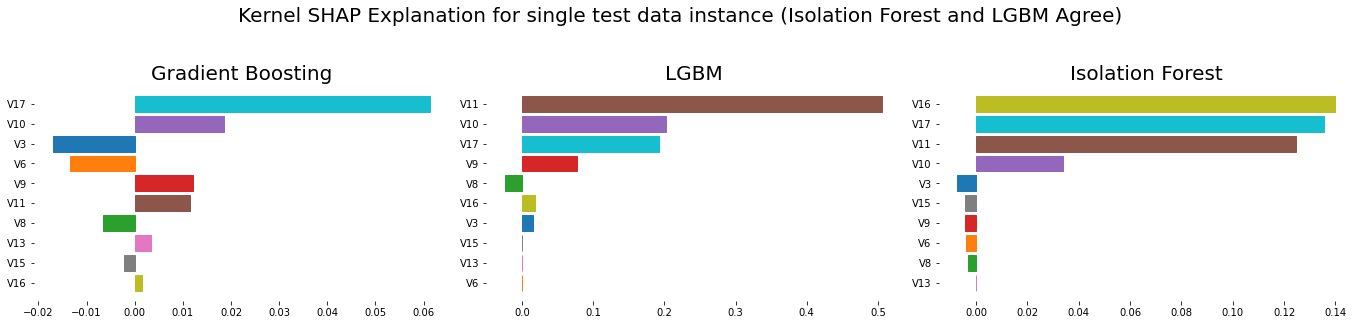

In [329]:
def plot_shap_exp(fig, fig_index, exp_data, title):
    features = list(exp_data.keys())[::-1]
    explanations = list(exp_data.values())[::-1]
    ax = fig.add_subplot(int(fig_index))
    lime_bar = ax.barh(features, explanations)
    ax.set_title(title, fontsize=20)
    for i, bar in enumerate(lime_bar):
        bar.set_color(color_list[list(current_data.columns).index(features[i])])
        plt.box(False)

shap_data_explainations=shap_data_explainations[:6]
# Plot SHAP explanations for a given test set item
fig = plt.figure(figsize=(19, 8))
for i, dex in enumerate(shap_data_explainations):
    fig_index = "23" + str(i + 1)
    plot_lime_exp(fig, fig_index, shap_data_explainations[i], trained_models[i]["name"])

plt.suptitle(
    "Kernel SHAP Explanation for single test data instance (Isolation Forest and LGBM Agree)",
    fontsize=20,
    fontweight="normal",
)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("exp19.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

# ENSEMBLING DETECTORS

Here, we create an ensemble of all three models  by stacking their predictions and using Microsoft's AutoML (FLAML) to to search for an optimised final learner.

In [389]:
X_data=np.array([[pred_GB[i],pred_IF[i],pred_LGBM[i]] for i in range(len(pred_GB))])
y_data= y_test

In [405]:
from flaml import AutoML
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 300,  # total running time in seconds
    "task": 'classification',  # task type
    "seed": 24545678,  # random seed
    "metric" : 'accuracy'}

automl.fit(X_train=X_data, y_train=y_data, **automl_settings)

[flaml.automl: 07-20 10:27:42] {2599} INFO - task = classification
[flaml.automl: 07-20 10:27:42] {2601} INFO - Data split method: stratified
[flaml.automl: 07-20 10:27:42] {2604} INFO - Evaluation method: cv
[flaml.automl: 07-20 10:27:42] {2726} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 07-20 10:27:42] {2870} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 07-20 10:27:42] {3166} INFO - iteration 0, current learner lgbm
[flaml.automl: 07-20 10:27:42] {3296} INFO - Estimated sufficient time budget=1064s. Estimated necessary time budget=25s.
[flaml.automl: 07-20 10:27:42] {3343} INFO -  at 0.1s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:27:42] {3166} INFO - iteration 1, current learner lgbm
[flaml.automl: 07-20 10:27:42] {3343} INFO -  at 0.2s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 1

[flaml.automl: 07-20 10:27:51] {3166} INFO - iteration 36, current learner extra_tree
[flaml.automl: 07-20 10:27:51] {3343} INFO -  at 9.1s,	estimator extra_tree's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:27:51] {3166} INFO - iteration 37, current learner xgboost
[flaml.automl: 07-20 10:27:51] {3343} INFO -  at 9.2s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:27:51] {3166} INFO - iteration 38, current learner xgboost
[flaml.automl: 07-20 10:27:51] {3343} INFO -  at 9.3s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:27:51] {3166} INFO - iteration 39, current learner rf
[flaml.automl: 07-20 10:27:52] {3343} INFO -  at 9.9s,	estimator rf's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:27:52] {3166} INFO - iteration 40, current learner xgboost
[flaml.automl: 07-20 10:27:52] {3343} INFO -  at 9.9s

[flaml.automl: 07-20 10:27:59] {3343} INFO -  at 16.6s,	estimator extra_tree's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:27:59] {3166} INFO - iteration 75, current learner lgbm
[flaml.automl: 07-20 10:27:59] {3343} INFO -  at 16.7s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:27:59] {3166} INFO - iteration 76, current learner lgbm
[flaml.automl: 07-20 10:27:59] {3343} INFO -  at 16.8s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:27:59] {3166} INFO - iteration 77, current learner xgboost
[flaml.automl: 07-20 10:27:59] {3343} INFO -  at 16.9s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:27:59] {3166} INFO - iteration 78, current learner rf
[flaml.automl: 07-20 10:28:00] {3343} INFO -  at 17.6s,	estimator rf's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.autom

[flaml.automl: 07-20 10:28:09] {3343} INFO -  at 26.5s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:09] {3166} INFO - iteration 113, current learner extra_tree
[flaml.automl: 07-20 10:28:09] {3343} INFO -  at 26.9s,	estimator extra_tree's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:09] {3166} INFO - iteration 114, current learner lgbm
[flaml.automl: 07-20 10:28:09] {3343} INFO -  at 27.0s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:09] {3166} INFO - iteration 115, current learner lgbm
[flaml.automl: 07-20 10:28:09] {3343} INFO -  at 27.1s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:09] {3166} INFO - iteration 116, current learner extra_tree
[flaml.automl: 07-20 10:28:10] {3343} INFO -  at 27.6s,	estimator extra_tree's best error=0.0007,	best estimator lgbm's best er

[flaml.automl: 07-20 10:28:15] {3343} INFO -  at 32.9s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:15] {3166} INFO - iteration 151, current learner xgboost
[flaml.automl: 07-20 10:28:15] {3343} INFO -  at 33.0s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:15] {3166} INFO - iteration 152, current learner xgboost
[flaml.automl: 07-20 10:28:15] {3343} INFO -  at 33.1s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:15] {3166} INFO - iteration 153, current learner lgbm
[flaml.automl: 07-20 10:28:15] {3343} INFO -  at 33.2s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:15] {3166} INFO - iteration 154, current learner lgbm
[flaml.automl: 07-20 10:28:15] {3343} INFO -  at 33.4s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[fla

[flaml.automl: 07-20 10:28:21] {3343} INFO -  at 39.3s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:21] {3166} INFO - iteration 189, current learner xgboost
[flaml.automl: 07-20 10:28:22] {3343} INFO -  at 39.4s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:22] {3166} INFO - iteration 190, current learner xgb_limitdepth
[flaml.automl: 07-20 10:28:22] {3343} INFO -  at 39.6s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:22] {3166} INFO - iteration 191, current learner xgb_limitdepth
[flaml.automl: 07-20 10:28:22] {3343} INFO -  at 39.7s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:22] {3166} INFO - iteration 192, current learner xgb_limitdepth
[flaml.automl: 07-20 10:28:22] {3343} INFO -  at 40.0s,	estimator xgb_limitdepth's best erro

[flaml.automl: 07-20 10:28:28] {3166} INFO - iteration 225, current learner lgbm
[flaml.automl: 07-20 10:28:28] {3343} INFO -  at 46.0s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:28] {3166} INFO - iteration 226, current learner xgboost
[flaml.automl: 07-20 10:28:28] {3343} INFO -  at 46.2s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:28] {3166} INFO - iteration 227, current learner lgbm
[flaml.automl: 07-20 10:28:28] {3343} INFO -  at 46.3s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:28] {3166} INFO - iteration 228, current learner xgb_limitdepth
[flaml.automl: 07-20 10:28:29] {3343} INFO -  at 46.5s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:29] {3166} INFO - iteration 229, current learner xgboost
[flaml.automl: 07-20 10:28:29] {3343} 

[flaml.automl: 07-20 10:28:37] {3166} INFO - iteration 262, current learner extra_tree
[flaml.automl: 07-20 10:28:38] {3343} INFO -  at 56.2s,	estimator extra_tree's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:38] {3166} INFO - iteration 263, current learner rf
[flaml.automl: 07-20 10:28:39] {3343} INFO -  at 56.8s,	estimator rf's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:39] {3166} INFO - iteration 264, current learner xgboost
[flaml.automl: 07-20 10:28:39] {3343} INFO -  at 56.9s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:39] {3166} INFO - iteration 265, current learner xgb_limitdepth
[flaml.automl: 07-20 10:28:39] {3343} INFO -  at 57.1s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:39] {3166} INFO - iteration 266, current learner xgb_limitdepth
[flaml.automl: 07-20 10

[flaml.automl: 07-20 10:28:51] {3166} INFO - iteration 299, current learner rf
[flaml.automl: 07-20 10:28:51] {3343} INFO -  at 69.3s,	estimator rf's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:51] {3166} INFO - iteration 300, current learner lgbm
[flaml.automl: 07-20 10:28:51] {3343} INFO -  at 69.4s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:51] {3166} INFO - iteration 301, current learner rf
[flaml.automl: 07-20 10:28:52] {3343} INFO -  at 70.1s,	estimator rf's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:52] {3166} INFO - iteration 302, current learner lgbm
[flaml.automl: 07-20 10:28:52] {3343} INFO -  at 70.2s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:28:52] {3166} INFO - iteration 303, current learner xgb_limitdepth
[flaml.automl: 07-20 10:28:53] {3343} INFO -  at 70.5s,	estimator

[flaml.automl: 07-20 10:29:01] {3166} INFO - iteration 337, current learner lgbm
[flaml.automl: 07-20 10:29:01] {3343} INFO -  at 79.2s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:01] {3166} INFO - iteration 338, current learner xgboost
[flaml.automl: 07-20 10:29:01] {3343} INFO -  at 79.3s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:01] {3166} INFO - iteration 339, current learner xgb_limitdepth
[flaml.automl: 07-20 10:29:02] {3343} INFO -  at 79.5s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:02] {3166} INFO - iteration 340, current learner lgbm
[flaml.automl: 07-20 10:29:02] {3343} INFO -  at 79.6s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:02] {3166} INFO - iteration 341, current learner rf
[flaml.automl: 07-20 10:29:03] {3343} INFO 

[flaml.automl: 07-20 10:29:12] {3166} INFO - iteration 374, current learner lgbm
[flaml.automl: 07-20 10:29:12] {3343} INFO -  at 90.0s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:12] {3166} INFO - iteration 375, current learner rf
[flaml.automl: 07-20 10:29:13] {3343} INFO -  at 90.7s,	estimator rf's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:13] {3166} INFO - iteration 376, current learner lgbm
[flaml.automl: 07-20 10:29:13] {3343} INFO -  at 90.8s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:13] {3166} INFO - iteration 377, current learner lgbm
[flaml.automl: 07-20 10:29:13] {3343} INFO -  at 91.0s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:13] {3166} INFO - iteration 378, current learner extra_tree
[flaml.automl: 07-20 10:29:15] {3343} INFO -  at 93.1s,	estimator

[flaml.automl: 07-20 10:29:25] {3343} INFO -  at 103.4s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:25] {3166} INFO - iteration 412, current learner rf
[flaml.automl: 07-20 10:29:27] {3343} INFO -  at 104.5s,	estimator rf's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:27] {3166} INFO - iteration 413, current learner lgbm
[flaml.automl: 07-20 10:29:27] {3343} INFO -  at 104.6s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:27] {3166} INFO - iteration 414, current learner xgboost
[flaml.automl: 07-20 10:29:27] {3343} INFO -  at 104.7s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:27] {3166} INFO - iteration 415, current learner lgbm
[flaml.automl: 07-20 10:29:27] {3343} INFO -  at 104.8s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.au

[flaml.automl: 07-20 10:29:38] {3166} INFO - iteration 449, current learner xgb_limitdepth
[flaml.automl: 07-20 10:29:38] {3343} INFO -  at 116.4s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:38] {3166} INFO - iteration 450, current learner xgb_limitdepth
[flaml.automl: 07-20 10:29:39] {3343} INFO -  at 116.5s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:39] {3166} INFO - iteration 451, current learner xgb_limitdepth
[flaml.automl: 07-20 10:29:39] {3343} INFO -  at 116.7s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:39] {3166} INFO - iteration 452, current learner xgb_limitdepth
[flaml.automl: 07-20 10:29:39] {3343} INFO -  at 116.8s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:39] {3166} INFO - iteration 453, curr

[flaml.automl: 07-20 10:29:50] {3166} INFO - iteration 486, current learner xgb_limitdepth
[flaml.automl: 07-20 10:29:50] {3343} INFO -  at 127.9s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:50] {3166} INFO - iteration 487, current learner xgboost
[flaml.automl: 07-20 10:29:50] {3343} INFO -  at 128.0s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:50] {3166} INFO - iteration 488, current learner extra_tree
[flaml.automl: 07-20 10:29:51] {3343} INFO -  at 129.0s,	estimator extra_tree's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:51] {3166} INFO - iteration 489, current learner xgboost
[flaml.automl: 07-20 10:29:51] {3343} INFO -  at 129.1s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:29:51] {3166} INFO - iteration 490, current learner xgboost
[flaml.automl: 0

[flaml.automl: 07-20 10:30:00] {3343} INFO -  at 137.6s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:00] {3166} INFO - iteration 524, current learner xgb_limitdepth
[flaml.automl: 07-20 10:30:00] {3343} INFO -  at 137.7s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:00] {3166} INFO - iteration 525, current learner xgb_limitdepth
[flaml.automl: 07-20 10:30:00] {3343} INFO -  at 137.9s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:00] {3166} INFO - iteration 526, current learner xgboost
[flaml.automl: 07-20 10:30:00] {3343} INFO -  at 138.0s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:00] {3166} INFO - iteration 527, current learner xgb_limitdepth
[flaml.automl: 07-20 10:30:00] {3343} INFO -  at 138.1s,	estimator xgb_limitdepth's b

[flaml.automl: 07-20 10:30:10] {3166} INFO - iteration 561, current learner xgboost
[flaml.automl: 07-20 10:30:10] {3343} INFO -  at 148.2s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:10] {3166} INFO - iteration 562, current learner xgboost
[flaml.automl: 07-20 10:30:10] {3343} INFO -  at 148.3s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:10] {3166} INFO - iteration 563, current learner extra_tree
[flaml.automl: 07-20 10:30:11] {3343} INFO -  at 149.4s,	estimator extra_tree's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:11] {3166} INFO - iteration 564, current learner lgbm
[flaml.automl: 07-20 10:30:12] {3343} INFO -  at 149.5s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:12] {3166} INFO - iteration 565, current learner lgbm
[flaml.automl: 07-20 10:30:12] {3343} I

[flaml.automl: 07-20 10:30:21] {3166} INFO - iteration 599, current learner xgboost
[flaml.automl: 07-20 10:30:21] {3343} INFO -  at 159.0s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:21] {3166} INFO - iteration 600, current learner xgboost
[flaml.automl: 07-20 10:30:21] {3343} INFO -  at 159.1s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:21] {3166} INFO - iteration 601, current learner rf
[flaml.automl: 07-20 10:30:22] {3343} INFO -  at 159.8s,	estimator rf's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:22] {3166} INFO - iteration 602, current learner rf
[flaml.automl: 07-20 10:30:23] {3343} INFO -  at 160.6s,	estimator rf's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:23] {3166} INFO - iteration 603, current learner extra_tree
[flaml.automl: 07-20 10:30:24] {3343} INFO -  at 161.

[flaml.automl: 07-20 10:30:34] {3166} INFO - iteration 637, current learner lrl1
[flaml.automl: 07-20 10:30:34] {3343} INFO -  at 172.2s,	estimator lrl1's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:34] {3166} INFO - iteration 638, current learner lrl1
[flaml.automl: 07-20 10:30:35] {3343} INFO -  at 172.4s,	estimator lrl1's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:35] {3166} INFO - iteration 639, current learner xgboost
[flaml.automl: 07-20 10:30:35] {3343} INFO -  at 172.6s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:35] {3166} INFO - iteration 640, current learner lrl1
[flaml.automl: 07-20 10:30:35] {3343} INFO -  at 172.8s,	estimator lrl1's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:35] {3166} INFO - iteration 641, current learner lgbm
[flaml.automl: 07-20 10:30:35] {3343} INFO -  at 172.9s,	

[flaml.automl: 07-20 10:30:45] {3166} INFO - iteration 675, current learner lgbm
[flaml.automl: 07-20 10:30:46] {3343} INFO -  at 183.5s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:46] {3166} INFO - iteration 676, current learner lrl1
[flaml.automl: 07-20 10:30:46] {3343} INFO -  at 183.8s,	estimator lrl1's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:46] {3166} INFO - iteration 677, current learner xgb_limitdepth
[flaml.automl: 07-20 10:30:46] {3343} INFO -  at 184.0s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:46] {3166} INFO - iteration 678, current learner xgboost
[flaml.automl: 07-20 10:30:46] {3343} INFO -  at 184.1s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:46] {3166} INFO - iteration 679, current learner lrl1
[flaml.automl: 07-20 10:30:46] {3343}

[flaml.automl: 07-20 10:30:56] {3166} INFO - iteration 713, current learner xgboost
[flaml.automl: 07-20 10:30:56] {3343} INFO -  at 194.3s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:56] {3166} INFO - iteration 714, current learner xgboost
[flaml.automl: 07-20 10:30:56] {3343} INFO -  at 194.4s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:56] {3166} INFO - iteration 715, current learner xgb_limitdepth
[flaml.automl: 07-20 10:30:57] {3343} INFO -  at 194.7s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:57] {3166} INFO - iteration 716, current learner rf
[flaml.automl: 07-20 10:30:58] {3343} INFO -  at 195.7s,	estimator rf's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:30:58] {3166} INFO - iteration 717, current learner xgboost
[flaml.automl: 07-20 10:30:58] {

[flaml.automl: 07-20 10:31:06] {3343} INFO -  at 204.1s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:06] {3166} INFO - iteration 751, current learner lrl1
[flaml.automl: 07-20 10:31:06] {3343} INFO -  at 204.4s,	estimator lrl1's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:06] {3166} INFO - iteration 752, current learner lrl1
[flaml.automl: 07-20 10:31:07] {3343} INFO -  at 204.7s,	estimator lrl1's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:07] {3166} INFO - iteration 753, current learner xgboost
[flaml.automl: 07-20 10:31:07] {3343} INFO -  at 204.7s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:07] {3166} INFO - iteration 754, current learner rf
[flaml.automl: 07-20 10:31:08] {3343} INFO -  at 205.5s,	estimator rf's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.au

[flaml.automl: 07-20 10:31:15] {3166} INFO - iteration 788, current learner xgboost
[flaml.automl: 07-20 10:31:15] {3343} INFO -  at 212.9s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:15] {3166} INFO - iteration 789, current learner lrl1
[flaml.automl: 07-20 10:31:15] {3343} INFO -  at 213.2s,	estimator lrl1's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:15] {3166} INFO - iteration 790, current learner xgb_limitdepth
[flaml.automl: 07-20 10:31:16] {3343} INFO -  at 213.6s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:16] {3166} INFO - iteration 791, current learner xgboost
[flaml.automl: 07-20 10:31:16] {3343} INFO -  at 213.7s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:16] {3166} INFO - iteration 792, current learner lrl1
[flaml.automl: 07-20 10:31:16] 

[flaml.automl: 07-20 10:31:28] {3343} INFO -  at 225.8s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:28] {3166} INFO - iteration 826, current learner xgb_limitdepth
[flaml.automl: 07-20 10:31:28] {3343} INFO -  at 225.9s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:28] {3166} INFO - iteration 827, current learner rf
[flaml.automl: 07-20 10:31:28] {3343} INFO -  at 226.4s,	estimator rf's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:28] {3166} INFO - iteration 828, current learner xgb_limitdepth
[flaml.automl: 07-20 10:31:29] {3343} INFO -  at 227.0s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:29] {3166} INFO - iteration 829, current learner lgbm
[flaml.automl: 07-20 10:31:29] {3343} INFO -  at 227.1s,	estimator lgbm's best error=0.0007,	best 

[flaml.automl: 07-20 10:31:38] {3166} INFO - iteration 863, current learner xgb_limitdepth
[flaml.automl: 07-20 10:31:38] {3343} INFO -  at 235.9s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:38] {3166} INFO - iteration 864, current learner lgbm
[flaml.automl: 07-20 10:31:38] {3343} INFO -  at 236.0s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:38] {3166} INFO - iteration 865, current learner xgb_limitdepth
[flaml.automl: 07-20 10:31:38] {3343} INFO -  at 236.3s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:38] {3166} INFO - iteration 866, current learner extra_tree
[flaml.automl: 07-20 10:31:39] {3343} INFO -  at 237.1s,	estimator extra_tree's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:39] {3166} INFO - iteration 867, current learner xgboost
[flaml.a

[flaml.automl: 07-20 10:31:47] {3166} INFO - iteration 900, current learner lrl1
[flaml.automl: 07-20 10:31:47] {3343} INFO -  at 245.3s,	estimator lrl1's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:47] {3166} INFO - iteration 901, current learner xgboost
[flaml.automl: 07-20 10:31:47] {3343} INFO -  at 245.4s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:47] {3166} INFO - iteration 902, current learner xgb_limitdepth
[flaml.automl: 07-20 10:31:48] {3343} INFO -  at 245.6s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:48] {3166} INFO - iteration 903, current learner extra_tree
[flaml.automl: 07-20 10:31:49] {3343} INFO -  at 246.8s,	estimator extra_tree's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:49] {3166} INFO - iteration 904, current learner lrl1
[flaml.automl: 07-20 10:3

[flaml.automl: 07-20 10:31:58] {3343} INFO -  at 255.9s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:58] {3166} INFO - iteration 938, current learner lgbm
[flaml.automl: 07-20 10:31:58] {3343} INFO -  at 256.0s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:58] {3166} INFO - iteration 939, current learner rf
[flaml.automl: 07-20 10:31:59] {3343} INFO -  at 256.9s,	estimator rf's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:59] {3166} INFO - iteration 940, current learner xgboost
[flaml.automl: 07-20 10:31:59] {3343} INFO -  at 257.1s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:31:59] {3166} INFO - iteration 941, current learner lrl1
[flaml.automl: 07-20 10:31:59] {3343} INFO -  at 257.4s,	estimator lrl1's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml

[flaml.automl: 07-20 10:32:07] {3166} INFO - iteration 975, current learner xgboost
[flaml.automl: 07-20 10:32:07] {3343} INFO -  at 265.4s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:32:07] {3166} INFO - iteration 976, current learner xgboost
[flaml.automl: 07-20 10:32:08] {3343} INFO -  at 265.5s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:32:08] {3166} INFO - iteration 977, current learner lrl1
[flaml.automl: 07-20 10:32:08] {3343} INFO -  at 265.9s,	estimator lrl1's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:32:08] {3166} INFO - iteration 978, current learner xgboost
[flaml.automl: 07-20 10:32:08] {3343} INFO -  at 266.0s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:32:08] {3166} INFO - iteration 979, current learner lrl1
[flaml.automl: 07-20 10:32:08] {3343} INFO - 

[flaml.automl: 07-20 10:32:24] {3166} INFO - iteration 1013, current learner rf
[flaml.automl: 07-20 10:32:24] {3343} INFO -  at 282.2s,	estimator rf's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:32:24] {3166} INFO - iteration 1014, current learner lgbm
[flaml.automl: 07-20 10:32:24] {3343} INFO -  at 282.3s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:32:24] {3166} INFO - iteration 1015, current learner xgb_limitdepth
[flaml.automl: 07-20 10:32:25] {3343} INFO -  at 282.6s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:32:25] {3166} INFO - iteration 1016, current learner xgb_limitdepth
[flaml.automl: 07-20 10:32:25] {3343} INFO -  at 282.7s,	estimator xgb_limitdepth's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:32:25] {3166} INFO - iteration 1017, current learner xgboost
[flaml.automl: 07-2

[flaml.automl: 07-20 10:32:35] {3343} INFO -  at 293.3s,	estimator lrl1's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:32:35] {3166} INFO - iteration 1051, current learner extra_tree
[flaml.automl: 07-20 10:32:37] {3343} INFO -  at 294.7s,	estimator extra_tree's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:32:37] {3166} INFO - iteration 1052, current learner lrl1
[flaml.automl: 07-20 10:32:37] {3343} INFO -  at 295.1s,	estimator lrl1's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:32:37] {3166} INFO - iteration 1053, current learner xgboost
[flaml.automl: 07-20 10:32:37] {3343} INFO -  at 295.1s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 07-20 10:32:37] {3166} INFO - iteration 1054, current learner lrl1
[flaml.automl: 07-20 10:32:38] {3343} INFO -  at 295.5s,	estimator lrl1's best error=0.0007,	best estimator lgbm's best er

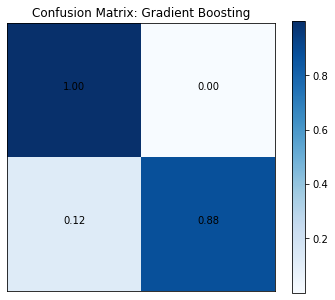

In [414]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
X =(X-X.mean())/X.std()
y=df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
cm = confusion_matrix(y_test, pred_GB)

# Normalize confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot heatmap using matplotlib
plt.figure(figsize=(6, 5))
plt.imshow(cmn, interpolation='nearest', cmap='Blues')

# Add text annotations
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        plt.text(j, i, format(cmn[i, j], '.2f'), horizontalalignment="center", color="black")

plt.colorbar()
plt.title('Confusion Matrix: Gradient Boosting')

# Disable x and y ticks
plt.xticks([])
plt.yticks([])
plt.savefig("exp20.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

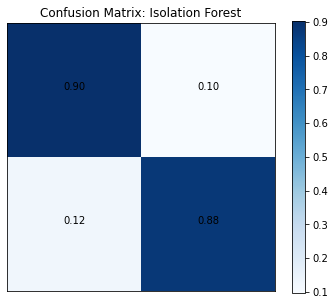

In [415]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_IF)

# Normalize confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot heatmap using matplotlib
plt.figure(figsize=(6, 5))
plt.imshow(cmn, interpolation='nearest', cmap='Blues')

# Add text annotations
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        plt.text(j, i, format(cmn[i, j], '.2f'), horizontalalignment="center", color="black")

plt.colorbar()
plt.title('Confusion Matrix: Isolation Forest')

# Disable x and y ticks
plt.xticks([])
plt.yticks([])
plt.savefig("exp21.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

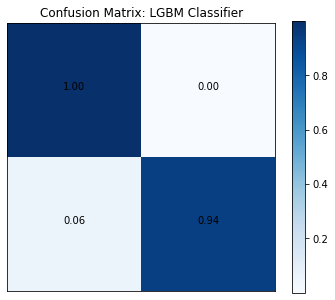

In [416]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_LGBM)

# Normalize confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot heatmap using matplotlib
plt.figure(figsize=(6, 5))
plt.imshow(cmn, interpolation='nearest', cmap='Blues')

# Add text annotations
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        plt.text(j, i, format(cmn[i, j], '.2f'), horizontalalignment="center", color="black")

plt.colorbar()
plt.title('Confusion Matrix: LGBM Classifier')

# Disable x and y ticks
plt.xticks([])
plt.yticks([])
plt.savefig("exp22.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

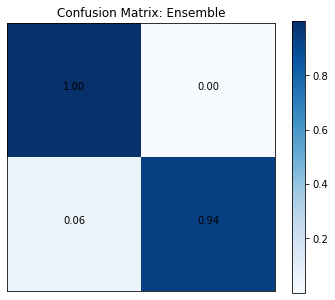

In [417]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
pred_ENS=automl.predict(X_data)
cm = confusion_matrix(y_data, pred_ENS)

# Normalize confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot heatmap using matplotlib
plt.figure(figsize=(6, 5))
plt.imshow(cmn, interpolation='nearest', cmap='Blues')

# Add text annotations
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        plt.text(j, i, format(cmn[i, j], '.2f'), horizontalalignment="center", color="black")

plt.colorbar()
plt.title('Confusion Matrix: Ensemble')

# Disable x and y ticks
plt.xticks([])
plt.yticks([])
plt.savefig("exp23.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

In [419]:
score_test_GB=Modls[0].predict_proba(X_test)
y_score_test_GB=score_test_GB[:,1]
score_test_LGBM=Modls[2].predict_proba(X_test)
y_score_LGBM=score_test_LGBM[:,1]

score_test_ENS=automl.predict_proba(X_data)
y_score_ENS=score_test_ENS[:,1]

y_score_IF=Modls[1].decision_function(X_test)

roc_GB=roc_auc_score(y_test,y_score_test_GB)
roc_IF=roc_auc_score(y_test,y_score_IF)
roc_LGBM=roc_auc_score(y_test,y_score_LGBM)
roc_ENS=roc_auc_score(y_test,y_score_ENS)
roc_ENS

0.9693372602525155

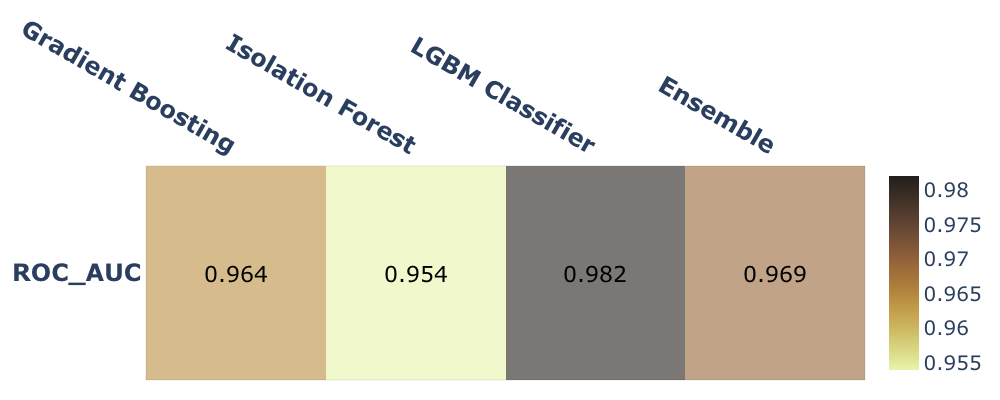

In [420]:
import numpy as np
import plotly.graph_objects as go
from functools import reduce
from itertools import product
from IPython.display import Image
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
z=[ [np.round(roc_GB,3),np.round(roc_IF,3),np.round(roc_LGBM,3),np.round(roc_ENS,3)]]
x=['<b>Gradient Boosting</b>', '<b>Isolation Forest</b>', '<b>LGBM Classifier</b>',  '<b>Ensemble</b>']
y=['<b>ROC_AUC</b>']

def get_anno_text(z_value):
    annotations=[]
    a, b = len(z_value), len(z_value[0])
    flat_z = reduce(lambda x,y: x+y, z_value) # z_value.flat if you deal with numpy
    coords = product(range(a), range(b))
    for pos, elem in zip(coords, flat_z):
        annotations.append({'font': {'color': 'black'},
                    'showarrow': False,
                    'text': str(elem),
                    'x': pos[1],
                    'y': pos[0],
                        'font.size':22   })
    return annotations

fig = go.Figure(data=go.Heatmap(
                   z=z,
                   x=x,
                   y=y,
                   hoverongaps = True, colorscale ='turbid',
    opacity=0.6,colorbar=dict(tickfont=dict(size=20)) ))#matter#

fig.update_layout(title={'text': "",
        'y':0.8,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
           plot_bgcolor='rgba(0,0,0,0)',       
    annotations = get_anno_text(z),
                 width=1000,
height=400,xaxis={'side': 'top'},margin=dict(l=20, r=20, t=20, b=20))

fig.update_xaxes(tickfont = dict(size=24),linewidth=0.1, linecolor='black',
    
                 mirror=True)
fig.update_yaxes(tickfont = dict(size=24),linewidth=0.1, linecolor='black',
        
                 mirror=True)
fig.write_image("table25.png",engine="kaleido")
#plt.savefig("table2a.pdf", format="pdf", bbox_inches="tight")
fig.show()
Image('table25.png')

 #### How does missing data impact anomaly detection? Are different anomaly detection algorithms better suited for datasets where there are more missing values?